# Trabajo Práctico 2

## 1. Implemente un perceptrón simple que aprenda la función lógica AND y la función lógica OR, de 2 y de 4 entradas. Muestre la evolución del error durante el entrenamiento. Para el caso de 2 dimensiones, grafique la recta discriminadora y todos los vectores de entrada de la red.

## Entrenamiento de un perceptrón con historial de pesos por época

El siguiente código implementa un **perceptrón simple** con *bias* absorbido, diseñado para tareas lógicas como **AND / OR**, y permite registrar la evolución de los **pesos** y del **error cuadrático medio (ECM)** a lo largo de las épocas de entrenamiento.

---

### Descripción general

El perceptrón es un clasificador lineal binario que actualiza sus pesos cada vez que comete un error.  
En este caso, se usa un vector aumentado (incluyendo el *bias*) para simplificar la regla de actualización.

El flujo de entrenamiento es el siguiente:

1. Se inicializan los pesos de forma aleatoria según una distribución normal **N(0, 0.01)**.  
2. En cada época, se recorren todas las muestras (en orden fijo o aleatorio).  
3. Si una muestra está mal clasificada, se ajustan los pesos.  
4. Al final de cada época, se guarda el vector de pesos y el ECM.  
5. Si no hay errores en una época, el entrenamiento se detiene (convergencia).

---

### Funciones principales

- **step(h)**  
  Función de activación por signo. Devuelve +1 si la entrada es mayor o igual a 0, y -1 en caso contrario.

- **augment_with_bias(X)**  
  Agrega una columna de unos a la matriz de entradas `X`, de modo que el último peso del vector `w` actúe como *bias*.  
  Esto permite tratar el *bias* como un peso más.

- **forward_aug(X_aug, w_aug)**  
  Calcula la salida del perceptrón (ya con la entrada aumentada) aplicando el producto punto entre las entradas y los pesos, seguido de la función de activación `step`.

- **predict(X, w_aug)**  
  Facilita la predicción sobre datos sin aumentar. Internamente llama a `augment_with_bias` y `forward_aug`.

- **mse(y_true, y_pred)**  
  Calcula el **Error Cuadrático Medio (ECM)** entre las etiquetas verdaderas y las predicciones.  
  Este valor se usa como métrica de desempeño durante el entrenamiento.

---

### Función de entrenamiento

**train_perceptron_aug_with_history(X, y, eta, max_epochs, shuffle, random_state)**  

Entrena el perceptrón de manera **en línea** (muestra por muestra) y guarda el historial de pesos y ECM.

**Parámetros:**
- **X**: matriz de entrenamiento, donde cada fila es un patrón de entrada.  
- **y**: vector de etiquetas en {+1, -1}.  
- **eta**: tasa de aprendizaje (valor pequeño, como 0.1).  
- **max_epochs**: número máximo de épocas.  
- **shuffle**: si es True, mezcla las muestras en cada época.  
- **random_state**: semilla aleatoria opcional para reproducibilidad.

**Retorna:**
- **w_hist**: matriz con los pesos finales de cada época (incluyendo el bias).  
- **ecms**: lista con el ECM calculado en cada época.

---

#### Criterio de parada

El entrenamiento se detiene de forma anticipada (**early stopping**) si en una época no hay errores de clasificación, lo que indica que el conjunto es linealmente separable.

---




In [1]:
import numpy as np
import matplotlib.pyplot as plt

def step(h: np.ndarray) -> np.ndarray:
    """Signo: +1 si h>=0, -1 si h<0."""
    return np.where(h >= 0, 1, -1)

def augment_with_bias(X: np.ndarray) -> np.ndarray:
    """Agrega una columna de 1s: X -> [X | 1]. El último peso es el bias."""
    X = np.asarray(X, dtype=float)
    ones = np.ones((X.shape[0], 1), dtype=float)
    return np.hstack([X, ones])

def forward_aug(X_aug: np.ndarray, w_aug: np.ndarray) -> np.ndarray:
    """Salida del perceptrón con X """
    return step(X_aug @ w_aug)

def predict(X: np.ndarray, w_aug: np.ndarray) -> np.ndarray:
    """Predice a partir de X (no aumentada)."""
    return forward_aug(augment_with_bias(X), w_aug)

def mse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """ECM sobre etiquetas en {+1,-1}."""
    y_true = np.asarray(y_true)
    return float(np.mean((y_true - y_pred) ** 2))

# -------------------------
# Entrenamiento con HISTORIAL por ÉPOCA
# -------------------------
def train_perceptron_aug_with_history(
    X: np.ndarray,
    y: np.ndarray,
    eta: float = 0.1,
    max_epochs: int = 100,
    shuffle: bool = False,
    random_state: int | None = None,
):
    rng = np.random.default_rng(random_state)
    X_aug = augment_with_bias(X)
    y = np.asarray(y, dtype=int)

    w_aug = rng.normal(0, 0.01, size=X_aug.shape[1])

    w_hist = []
    ecms = []

    for _ in range(max_epochs):
        if shuffle:
            idx = rng.permutation(len(X_aug))
            Xe, ye = X_aug[idx], y[idx]
        else:
            Xe, ye = X_aug, y

        mistakes = 0
        for xi, ti in zip(Xe, ye):
            if step(xi @ w_aug) != ti:
                w_aug += eta * ti * xi
                mistakes += 1

        # log de fin de época SIEMPRE
        w_hist.append(w_aug.copy())
        ecms.append(mse(y, forward_aug(X_aug, w_aug)))

        if mistakes == 0:  # early stop si separó perfecto
            break

    return np.array(w_hist), np.array(ecms)


### Funciones para generar datos, graficar y ejecutar experimentos

**`dataset_gate(gate="AND", dim=2)`**  
Genera el conjunto de datos correspondiente a la compuerta lógica elegida (**AND** u **OR**).  
Para `dim=2`, el dataset es:

- **Entradas:**  
  $X = \{(0,0), (0,1), (1,0), (1,1)\}$

- **Salidas:**  
  - **AND:** $y = \{-1, -1, -1, +1\}$  
  - **OR:** $y = \{-1, +1, +1, +1\}$

Para `dim=4`, genera todas las combinaciones binarias de 4 bits (16 patrones), con salidas análogas para **AND** y **OR**.

---

**`plot_boundary_on_ax(ax, w_aug)`**  
Dibuja la **frontera de decisión** del perceptrón en el eje `ax` a partir del vector de pesos aumentado  
$w_{\text{aug}} = [w_1, w_2, w_b]$, donde $w_b$ es el *bias*.  
La ecuación de la recta de decisión es:

$$
w_1 x_1 + w_2 x_2 + w_b = 0
\quad \Rightarrow \quad
x_2 = -\frac{w_1 x_1 + w_b}{w_2}
$$

Si $w_2 = 0$, la frontera es vertical ($x_1 = -w_b / w_1$).

---

**`annotate_points(ax, X, y)`**  
Dibuja los puntos del conjunto de datos `X` y los colorea según su clase.  
Además, agrega etiquetas de texto con los valores de salida (+1 o −1).  
Incluye ejes y cuadrícula para facilitar la lectura.

---

**`run_experiment_for_gate(gate, etas, max_epochs, shuffle, random_state)`**  
Ejecuta un experimento completo para una compuerta lógica determinada (**AND** u **OR**) y una lista de tasas de aprendizaje.

Para cada valor de **η (eta)** realiza los siguientes pasos:

1. **Entrena** el perceptrón con `train_perceptron_aug_with_history`, obteniendo:  
   - El historial de pesos por época (`w_hist`).  
   - El error cuadrático medio (`ecms`) por época.  

2. **Grafica el ECM vs. época** para visualizar la convergencia del entrenamiento.

3. **Muestra la evolución de la frontera de decisión** en un panel de subgráficos, uno por cada época, para observar cómo el perceptrón ajusta su frontera a lo largo del entrenamiento.

El procedimiento permite comparar distintas tasas de aprendizaje y visualizar cómo influyen en la **velocidad de convergencia** y en la **estabilidad del entrenamiento**.


In [2]:
def dataset_gate(gate: str = "AND", dim: int = 2):
    g = gate.strip().lower()
    if dim == 2:
        X = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=float)
        if g == "and":
            y = np.array([-1,-1,-1, 1], dtype=int)
        elif g == "or":
            y = np.array([-1, 1, 1, 1], dtype=int)
        else:
            raise ValueError("gate debe ser 'AND' u 'OR'")
        return X, y
    elif dim == 4:
        X = np.array([[int(b) for b in f"{i:04b}"] for i in range(16)], dtype=float)
        if g == "and":
            y = np.array([-1]*15 + [1], dtype=int)
        elif g == "or":
            y = np.array([-1] + [1]*15, dtype=int)
        else:
            raise ValueError("gate debe ser 'AND' u 'OR'")
        return X, y
    else:
        raise ValueError("dim debe ser 2 o 4")


def plot_boundary_on_ax(ax, w_aug, eps: float = 1e-12):
    """Dibuja la frontera de decisión en el eje ax dado w_aug."""
    w1, w2, wb = w_aug
    x_vals = np.linspace(-0.2, 1.2, 200)
    if abs(w2) > eps:
        y_vals = -(w1 * x_vals + wb) / w2
        ax.plot(x_vals, y_vals, linewidth=2)
    elif abs(w1) > eps:
        ax.axvline(x=-wb / w1, linewidth=2)


def annotate_points(ax, X, y):
    """Plotea puntos y etiquetas de clase."""
    X_pos = X[y == 1]; X_neg = X[y == -1]
    ax.scatter(X_pos[:,0], X_pos[:,1], label="+1")
    ax.scatter(X_neg[:,0], X_neg[:,1], label="-1")
    for pt, lab in zip(X, y):
        ax.annotate(str(int(lab)), (pt[0]+0.02, pt[1]+0.02), fontsize=9)
    ax.set_xlim(-0.2, 1.2); ax.set_ylim(-0.2, 1.2)
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xlabel("$x_1$"); ax.set_ylabel("$x_2$")
    ax.grid(True)

def run_experiment_for_gate(
    gate: str = "AND",
    etas = (0.01, 0.05, 0.1, 0.5, 1.0),
    max_epochs: int = 100,
    shuffle: bool = False,
    random_state: int = 42,
):
    """
    Para la compuerta 'gate' entrena con cada eta, grafica:
      (1) ECM vs. época y (2) evolución lateral de la frontera por época.
    Requiere train_perceptron_aug_with_history(X,y,eta,...) definido previamente.
    """
    X, y = dataset_gate(gate)
    for eta in etas:
        w_hist, ecms = train_perceptron_aug_with_history(
            X, y, eta=eta, max_epochs=max_epochs, shuffle=shuffle, random_state=random_state
        )

        xs = np.arange(1, len(ecms)+1)
        plt.figure(figsize=(5,3))
        if len(ecms) == 1:
            plt.scatter(xs, ecms, s=60)
        else:
            plt.plot(xs, ecms, marker='o')
        plt.xlabel("Época"); plt.ylabel("ECM")
        plt.title(f"ECM por época – {gate.upper()} (2) – η={eta}")
        plt.grid(True)
        plt.show()

        n_ep = len(w_hist)
        fig, axes = plt.subplots(1, n_ep, figsize=(3*n_ep, 3), sharex=True, sharey=True)
        if n_ep == 1:
            axes = [axes]

        for i, ax in enumerate(axes, start=1):
            annotate_points(ax, X, y)
            plot_boundary_on_ax(ax, w_hist[i-1])
            ax.set_title(f"época {i}")
            if i == 1:
                ax.legend(loc="upper left", frameon=True)

        fig.suptitle(f"{gate.upper()} (2) – evolución de la frontera – η={eta}", y=1.05, fontsize=12)
        plt.tight_layout()
        plt.show()


Analizamos **exclusivamente la compuerta lógica AND (2 entradas)**: entrenamos un perceptrón, registramos el **ECM por época** y mostramos, **para cada** $\eta$, dos gráficos: (1) **ECM vs. época** y (2) la **evolución de la recta discriminadora** *epoch a epoch*. (No se usa OR en este bloque.)


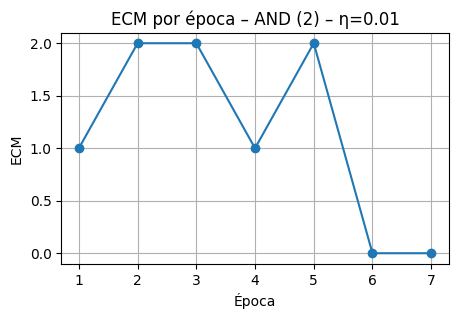

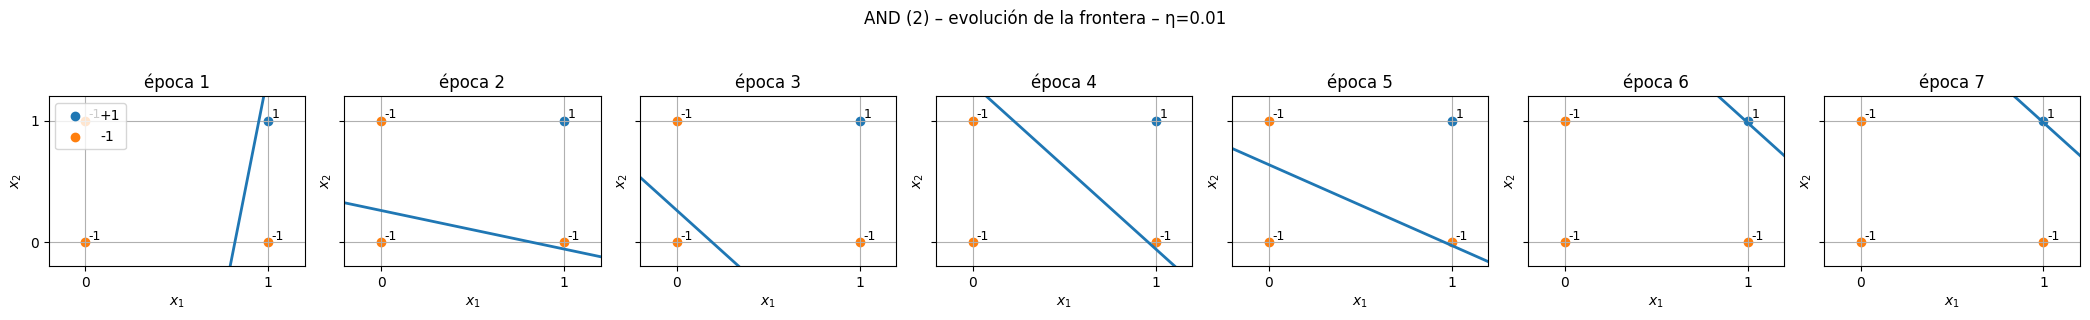

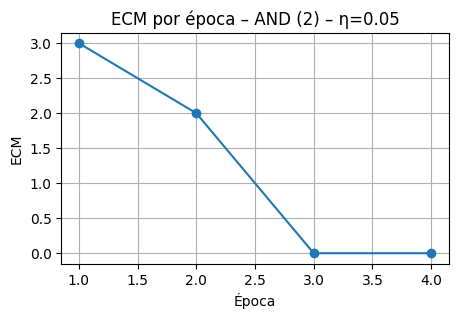

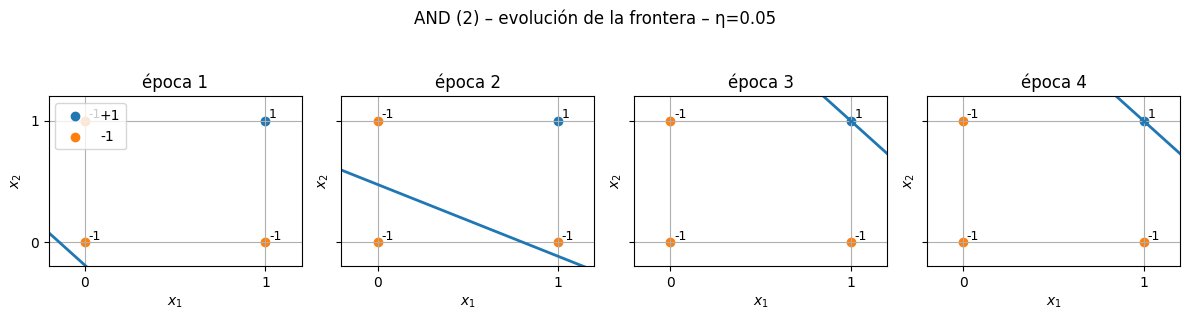

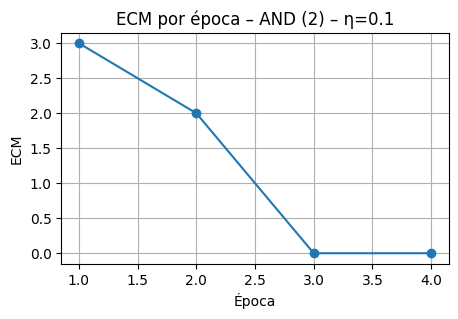

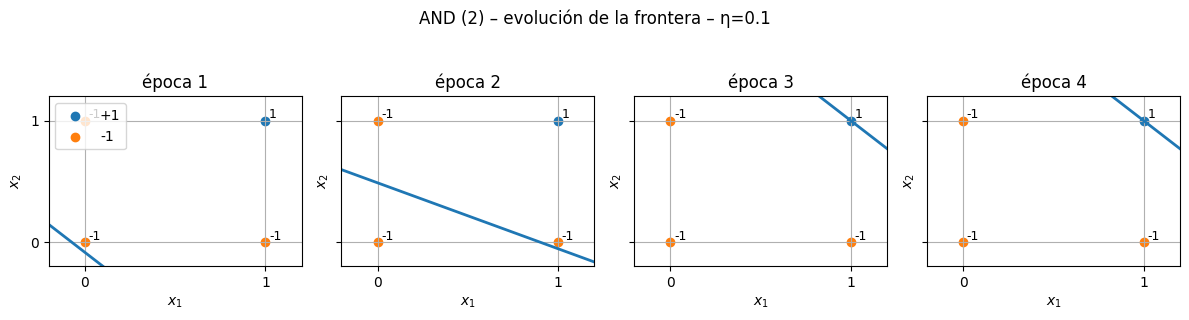

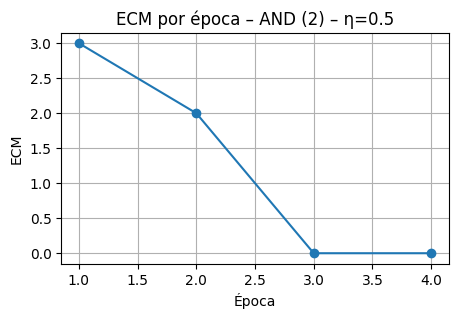

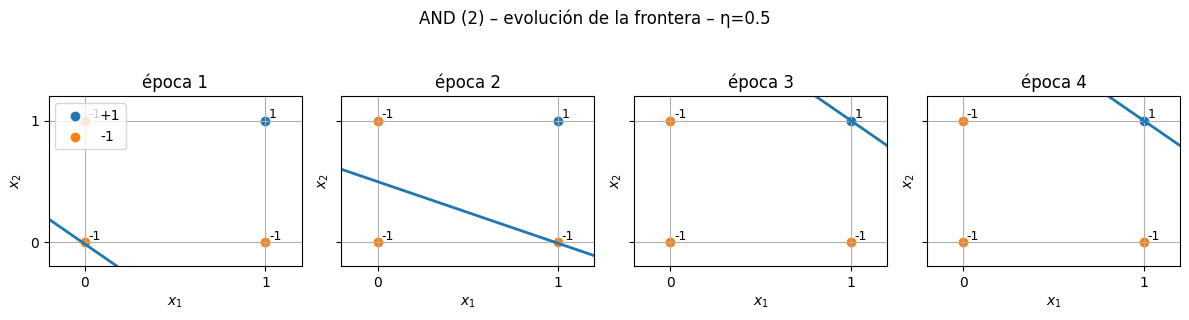

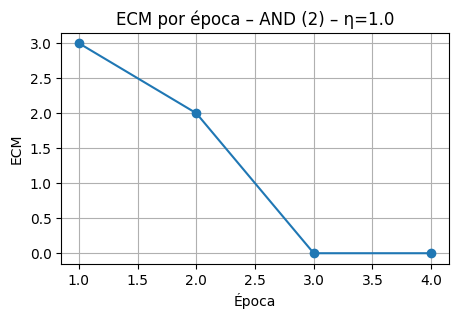

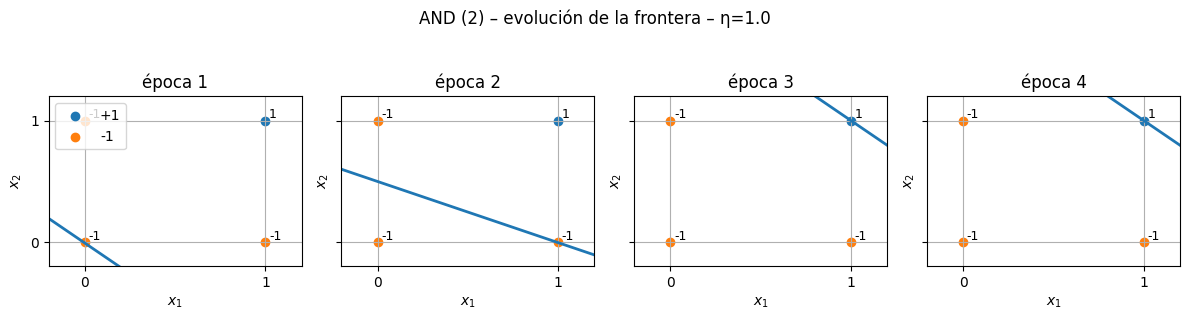

In [3]:
run_experiment_for_gate("AND", etas=[0.01, 0.05, 0.1, 0.5, 1.0], max_epochs=100, shuffle=False, random_state=42)


Analizamos **exclusivamente la compuerta lógica OR (2 entradas)**: entrenamos un perceptrón, registramos el **ECM por época** y mostramos, **para cada** $\eta$, dos gráficos: (1) **ECM vs. época** y (2) la **evolución de la recta discriminadora** *epoch a epoch*.  
Datos usados: $X\in\{0,1\}^2$ y $y=\{-1,\; +1,\; +1,\; +1\}$. (No se usa AND en este bloque.)


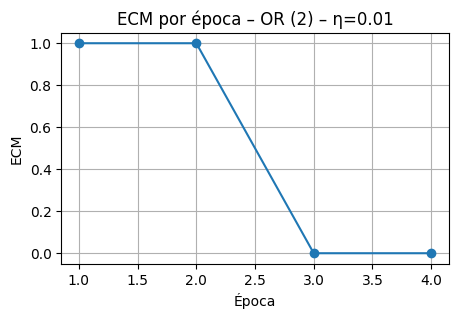

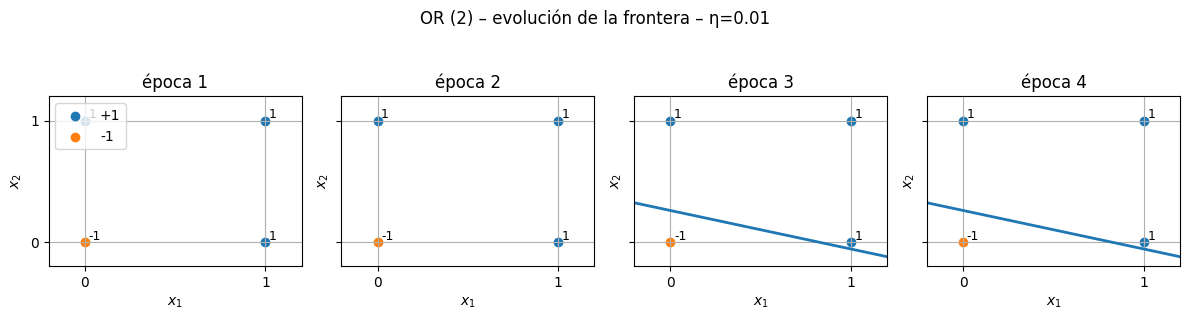

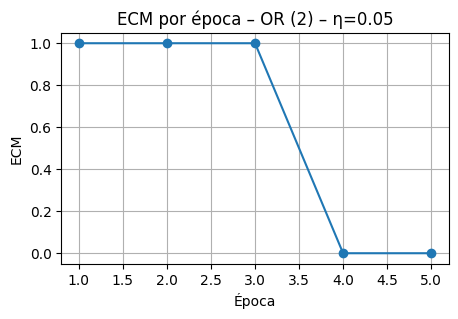

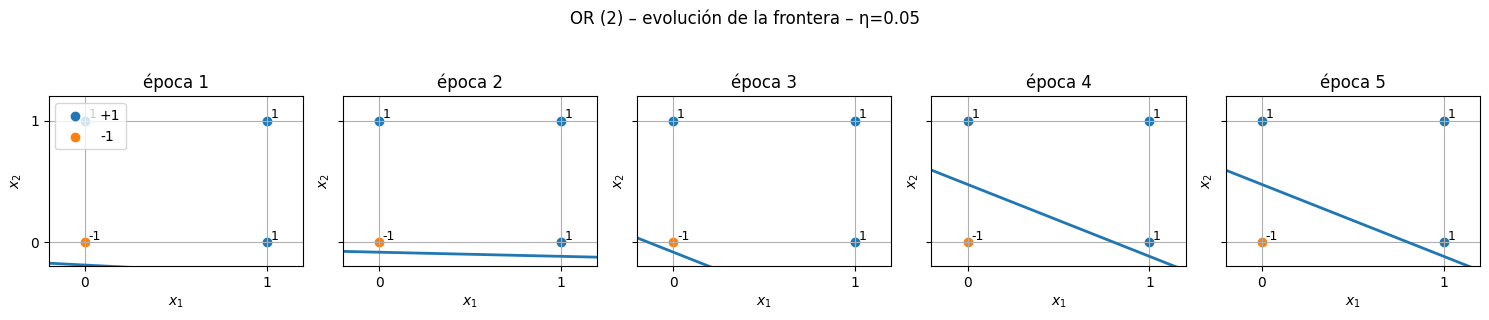

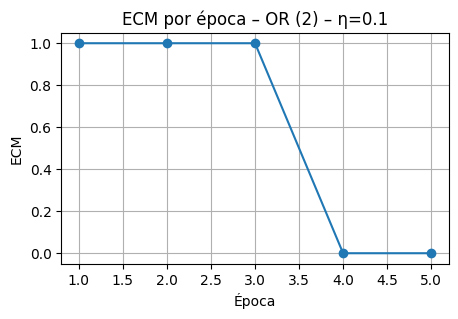

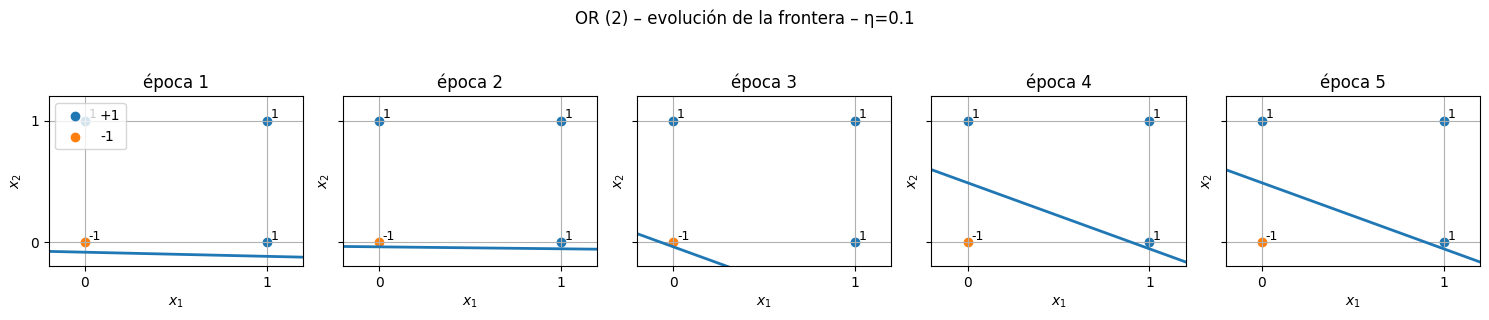

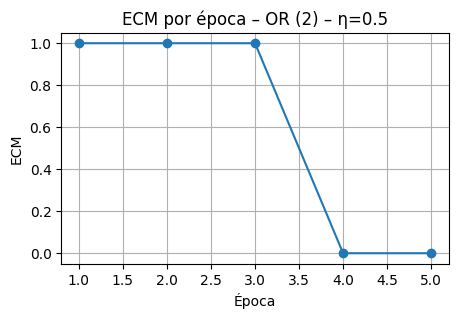

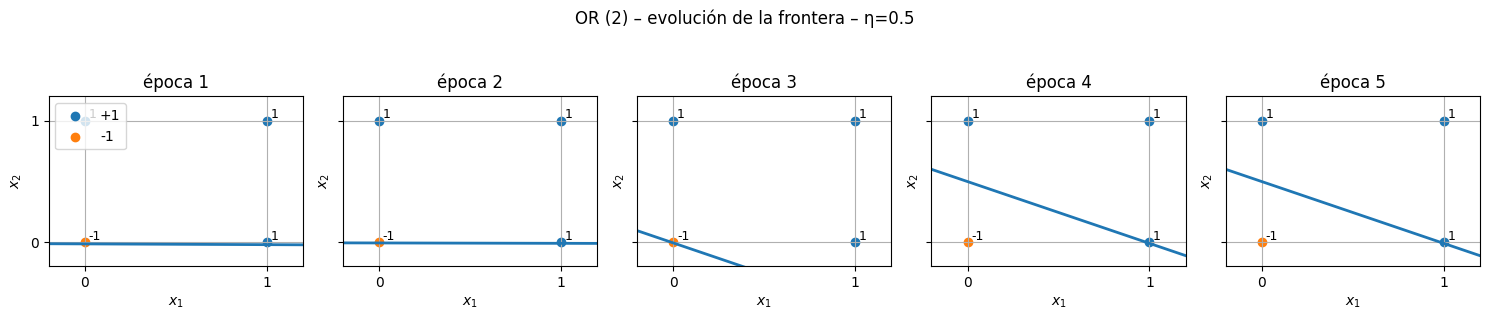

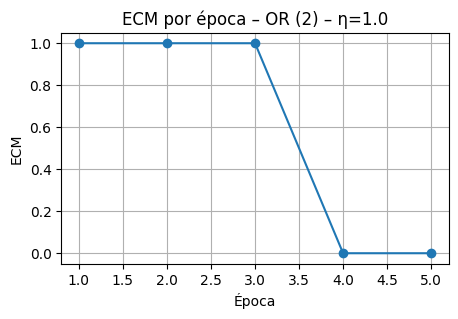

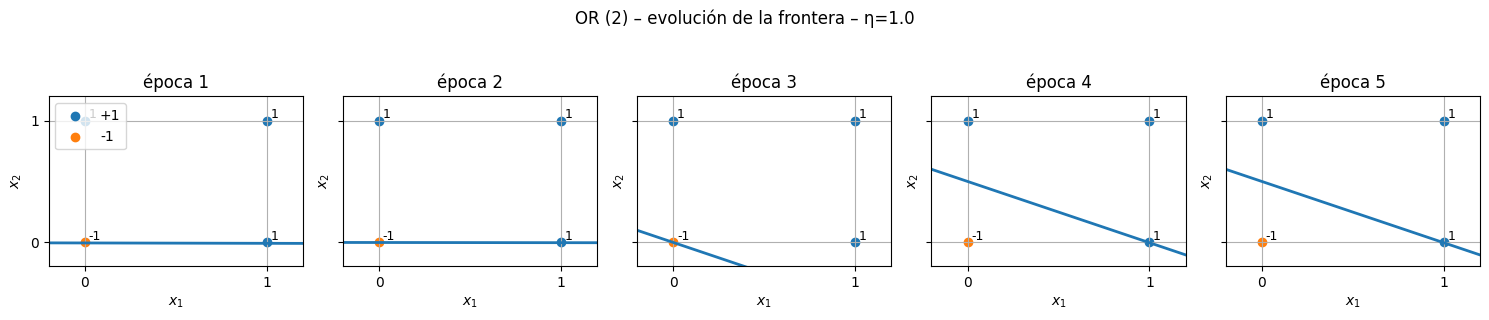

In [4]:
run_experiment_for_gate("OR", etas=[0.01, 0.05, 0.1, 0.5, 1.0], max_epochs=100, shuffle=False, random_state=42)


# 2. Determine numéricamente cómo varía la capacidad del perceptrón simple en función del número de patrones enseñados. Q

## Experimento de Capacidad del Perceptrón Simple

El objetivo es estimar **cuántos patrones aleatorios puede aprender un perceptrón simple con $N$ entradas**.  
La idea central es que el perceptrón solo puede resolver problemas **linealmente separables**, es decir, aquellos donde existe un hiperplano en $\mathbb{R}^N$ que divide perfectamente a las dos clases.

---

### Metodología del experimento

1. **Generación de problemas aleatorios:**  
   - Se eligen $N$ (número de entradas) y $N_p$ (número de patrones).  
   - Cada patrón es un vector $x \in [-1,1]^N$ generado al azar.  
   - A cada patrón se le asigna una etiqueta $y \in \{-1,+1\}$ también al azar.

2. **Entrenamiento del perceptrón:**  
   - Se entrena con regla del perceptrón clásico hasta un máximo de épocas.  
   - Se considera que el problema fue **aprendido** solo si el perceptrón logra error de entrenamiento exactamente 0:
     $$
     \forall i,\;\; \hat{y}_i = y_i
     $$

3. **Estimación de la fracción aprendida:**  
   - Se repite el procedimiento muchas veces (trials independientes).  
   - Se calcula:
     $$
     \text{frac}(N_p) \;=\; \frac{\# \text{problemas aprendidos}}{\text{trials}}
     $$

4. **Curvas de capacidad:**  
   - Para cada $N$, se varía $N_p$ desde 1 hasta un múltiplo de $N$ (por ejemplo, $5N$).  
   - Se grafica la fracción aprendida en función de $N_p$.  

---

### Qué vamos a medir

- Eje $x$: número de patrones $N_p$.  
- Eje $y$: fracción de problemas aprendidos (probabilidad de separabilidad lineal).  

El resultado son curvas que empiezan en 1 (pocos patrones casi siempre separables) y decaen hacia 0 (muchos patrones casi nunca separables).  
El **punto medio** ($N_p^*$) se toma como la **capacidad empírica del perceptrón**, definida como el número de patrones que puede aprender en promedio.

---

### Resultado esperado

Según la teoría clásica (Cover, 1965), la capacidad está en torno a:
$$
N_p^* \;\approx\; 2N
$$

Es decir, un perceptrón simple puede aprender, en promedio, hasta aproximadamente el **doble de patrones que la cantidad de entradas** antes de que la probabilidad de éxito caiga al 50%.


In [5]:
def _predict_from_w(X, w_aug):
    """Predicción {+1,-1} usando vector aumentado y pesos finales."""
    Xa = augment_with_bias(X)
    return np.where(Xa @ w_aug >= 0, 1, -1)

def _trial_learned_once(N: int, Np: int, eta=0.1, max_epochs=200, rng=None) -> bool:
    """
    Un problema aleatorio continuo:
      - X ~ U([-1,1]^N) de tamaño Np
      - y ∈ {-1,+1} al azar
    Entrena perceptrón; True si clasifica 100% en training.
    """
    if rng is None:
        rng = np.random.default_rng()
    X = rng.uniform(-1.0, 1.0, size=(Np, N))
    y = rng.choice([-1, 1], size=Np)

    # random_state distinto por trial (para inicialización)
    rs = int(rng.integers(0, 1_000_000))
    w_hist, _ = train_perceptron_aug_with_history(
        X, y, eta=eta, max_epochs=max_epochs, shuffle=False, random_state=rs
    )
    yhat = _predict_from_w(X, w_hist[-1])
    return bool(np.all(yhat == y))

def capacity_sweep(Ns, k_factor=5, trials=100, eta=0.1, max_epochs=500, seed=2025):
    """
    Para cada N y Np=1..k_factor*N, estima la fracción de problemas
    aprendidos (linealmente separables) por el perceptrón.
    Devuelve: dict N -> (Np_values, frac_learned)
    """
    rng_master = np.random.default_rng(seed)
    results = {}
    for N in Ns:
        Np_vals = np.arange(1, k_factor * N + 1)
        fracs = np.empty_like(Np_vals, dtype=float)
        for j, Np in enumerate(Np_vals):
            success = 0
            for _ in range(trials):
                rng = np.random.default_rng(int(rng_master.integers(0, 1_000_000)))
                success += _trial_learned_once(N, int(Np), eta=eta, max_epochs=max_epochs, rng=rng)
            fracs[j] = success / trials
        results[N] = (Np_vals, fracs)
    return results

def half_capacity_point(Np_vals, fracs):
    """Np* donde la fracción está más cerca de 0.5 (estimación de capacidad)."""
    idx = int(np.argmin(np.abs(fracs - 0.5)))
    return int(Np_vals[idx]), float(fracs[idx])


## Experimento ejecutado: Capacidad empírica del perceptrón simple

En este bloque de código variamos **la dimensión del perceptrón ($N$)** y el número de **trials** (repeticiones del experimento aleatorio) para estimar de manera robusta la capacidad.

---

### Configuración usada

- **Dimensiones comparadas ($N$):** $2, 4, 8, 20, 30$  
- **Cantidad de patrones probados ($N_p$):** desde 1 hasta $5 \cdot N$ (con `k_factor=5`).  
- **Tasa de aprendizaje:** $\eta = 0.1$  
- **Épocas máximas:** 500  
- **Semilla aleatoria:** 2854  
- **Número de trials:** $50$, $100$ y $500$

---

### Qué se midió

1. Para cada $N$ y cada $N_p$, se generaron problemas aleatorios con entradas continuas en $[-1,1]^N$ y salidas en $\{-1,+1\}$.  
2. Se entrenó un perceptrón simple y se contó como **aprendido** solo si alcanzó **error de entrenamiento 0**.  
3. Se repitió el procedimiento varias veces (`trials`) y se calculó la **fracción de problemas aprendidos**:
   $$
   \text{frac}(N_p) \;=\; \frac{\# \text{problemas aprendidos}}{\text{trials}}
   $$
4. Se graficó la curva $\text{frac}(N_p)$ para cada $N$ y se marcó con una línea roja punteada la referencia teórica en $2N$.  

---

### Resultados esperados

- Las curvas comienzan cerca de 1 (cuando $N_p$ es chico, casi siempre son separables).  
- A medida que $N_p$ aumenta, la fracción de problemas aprendidos cae hacia 0.  
- El punto medio ($N_p^*$, donde la fracción ≈ 0.5) aparece aproximadamente en $2N$, confirmando la predicción teórica de que la capacidad del perceptrón simple es cercana al doble de la dimensión de entrada.

---


In [6]:
# Config global
#Ns         = (2, 4, 8, 20, 30)     # dimensiones a comparar
Ns = (4,)
k_factor   = 5             # Np max = k_factor * N
eta        = 0.1
max_epochs = 500
seed       = 2854
#trials_list = [10, 50, 100, 500]
trials_list = []

for trials in trials_list:
    print(f"\n=== TRIALS = {trials} ===")
    results = capacity_sweep(
        Ns=Ns, k_factor=k_factor, trials=trials,
        eta=eta, max_epochs=max_epochs, seed=seed
    )

    # Plots por N
    for N, (Np_vals, fracs) in results.items():
        plt.figure(figsize=(5,3.5))
        plt.plot(Np_vals, fracs, marker='o', label="Fracción aprendida")

        # --- MARCA en 2N ---
        plt.axvline(2*N, color="red", linestyle="--", label=f"2N={2*N}")

        plt.xlabel("Número de patrones (Np)")
        plt.ylabel("Fracción aprendida")
        plt.title(f"Capacidad empírica – Perceptrón simple (N={N}) | trials={trials}")
        plt.ylim(-0.02, 1.02)
        plt.grid(True)
        plt.legend()
        plt.show()

    # Resumen de Np* (fracción ≈ 0.5)
    print("Np* (aprox. fracción≈0.5) por N:")
    for N, (Np_vals, fracs) in results.items():
        Np_star, frac = half_capacity_point(Np_vals, fracs)
        print(f"  N={N}: Np*≈{Np_star} (fracción={frac:.2f})")


# 3. Implemente un perceptrón multicapa que aprenda la función lógica XOR de 2 y de 4 entradas (utilizando el algoritmo Backpropagation y actualizando en batch). Muestre cómo evoluciona el error durante el entrenamiento. 

Este código implementa una red neuronal multicapa (MLP)

### 1. **Funciones de Activación**

Las funciones de activación son fundamentales para introducir no linealidad en el modelo, lo que le permite aprender representaciones complejas. El código soporta las siguientes funciones de activación:

- **Sigmoid**: 
  $$ \sigma(x) = \frac{1}{1 + e^{-x}} $$
  - La salida es entre 0 y 1. Comúnmente usada para problemas de clasificación binaria.

- **Tanh**: 
  $$ \tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}} $$
  - La salida es entre -1 y 1, y es útil cuando se necesita que los valores estén centrados alrededor de 0.

- **ReLU (Rectified Linear Unit)**: 
  $$ \text{ReLU}(x) = \max(0, x) $$
  - Amplia la activación de las neuronas y es muy utilizada por su eficiencia computacional y su capacidad para evitar el desvanecimiento del gradiente.

- **Identidad (Linear)**: 
  $$ f(x) = x $$
  - Usada típicamente en la capa de salida para problemas de regresión, donde la salida puede ser cualquier número real.

Cada función tiene también su derivada correspondiente, que se usa durante el proceso de retropropagación (backpropagation).

### 2. **Inicialización de Pesos**

La **inicialización de los pesos** en redes neuronales es crucial para un buen entrenamiento. En este código, se utilizan dos métodos de inicialización de pesos:

- **Inicialización de Xavier/Glorot**: 
  Esta inicialización es adecuada para funciones de activación como **sigmoid**, **tanh** o **linear**. Los pesos se inicializan con una distribución uniforme con el siguiente límite:
  $$ \text{limite} = \sqrt{\frac{6}{\text{fan\_in} + \text{fan\_out}}} $$

- **Inicialización de He**: 
  Usada para **ReLU**. Se inicializan los pesos con una distribución normal con desviación estándar:
  $$ \text{std} = \sqrt{\frac{2}{\text{fan\_in}}} $$

En ambos casos, los **bias** se inicializan a 0.

### 3. **Red Neuronal Multicapa (MLP)**

La clase `MLP` representa una red neuronal multicapa con la posibilidad de tener múltiples capas ocultas y de salida. Esta clase permite realizar las siguientes operaciones:

3.1 **Forward Pass**

El **forward pass** calcula la salida de la red para una entrada dada. Para cada capa, la salida se calcula como:

$$
Z = A \cdot W + b
$$
donde \( A \) es la activación de la capa anterior, \( W \) es el peso de la capa actual, y \( b \) es el bias.

La salida de cada capa se pasa a través de la función de activación correspondiente.

3.2 **Backward Pass (Retropropagación)**

En el **backpropagation**, se calculan los gradientes de los pesos y biases con respecto a la pérdida usando la regla de la cadena. La derivada de la función de activación se aplica a los errores para ajustar los pesos de la red.

La fórmula para calcular los gradientes de los pesos y biases es:

$$
\delta_i = g'(Z_i) \cdot (C_i - O_i)
$$
donde \( \delta_i \) es el error de la capa \( i \), \( g'(Z_i) \) es la derivada de la activación, y \( C_i \) y \( O_i \) son el valor objetivo y la salida de la red, respectivamente.

3.3 **Actualización de Pesos**

Después de calcular los gradientes, los pesos y biases se actualizan usando la regla de gradiente descendente. El aprendizaje es controlado por la tasa de aprendizaje (\( \eta \)):

$$
W_i = W_i - \eta \cdot \nabla W_i
$$
donde \( \nabla W_i \) es el gradiente de los pesos.

### 4. **Entrenamiento (fit)**

El método `fit()` entrena la red utilizando **mini-batches**. Durante el entrenamiento, la red realiza un **forward pass**, calcula la pérdida, realiza el **backward pass** y actualiza los pesos con la regla de gradiente descendente. El error de la red se guarda durante cada época de entrenamiento, y el modelo se evalúa con un conjunto de validación si se proporciona.

- **Early Stopping**: Si se proporciona un conjunto de validación, el entrenamiento puede detenerse temprano si el error de validación deja de mejorar después de un número de épocas.

### 5. **Predicción**

El método `predict()` se utiliza para realizar predicciones usando el modelo entrenado. Devuelve la salida de la red para un conjunto de entradas.

### 6. **Clasificación**

El método `predict_classes()` devuelve las predicciones de clase para problemas de clasificación. Si la salida es binaria (solo una neurona en la capa de salida), usa un umbral (por defecto 0.5) para decidir si la clase es 0 o 1. Si la salida es de varias clases (una neurona por clase), toma la clase con la activación más alta.

---

Este código implementa una red neuronal completa con múltiples capas ocultas y de salida, y proporciona los elementos necesarios para entrenar y hacer predicciones en tareas de clasificación y regresión. La inicialización de los pesos y las funciones de activación juegan un papel clave en la eficiencia del entrenamiento y el rendimiento del modelo.


In [7]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# Utilidades: activaciones
# ------------------------------
class Activations:
    @staticmethod
    def sigmoid(x):
        # numéricamente estable
        x = np.clip(x, -60, 60)
        return 1.0 / (1.0 + np.exp(-x))

    @staticmethod
    def d_sigmoid(a):
        # derivada en función de la salida activada (a = sigmoid(x))
        return a * (1.0 - a)

    @staticmethod
    def tanh(x):
        # np.tanh ya es estable
        return np.tanh(x)

    @staticmethod
    def d_tanh(a):
        # derivada en función de la salida activada (a = tanh(x))
        return 1.0 - a**2

    @staticmethod
    def relu(x):
        return np.maximum(0.0, x)

    @staticmethod
    def d_relu(a):
        return (a > 0.0).astype(a.dtype)

    @staticmethod
    def identity(x):
        return x

    @staticmethod
    def d_identity(a):
        return np.ones_like(a)

ACTS = {
    "sigmoid": (Activations.sigmoid, Activations.d_sigmoid),
    "tanh":    (Activations.tanh,    Activations.d_tanh),
    "relu":    (Activations.relu,    Activations.d_relu),
    "linear":  (Activations.identity,Activations.d_identity),
    "identity":(Activations.identity,Activations.d_identity),
}

# ------------------------------
# Inicialización de pesos
# ------------------------------
def weight_init(fan_in, fan_out, act_name, rng):
    """
    Xavier (sigmoid/tanh/linear) o He (ReLU). Retorna W, b.
    """
    act = act_name.lower()
    if act in ("relu",):
        # He normal
        std = np.sqrt(2.0 / fan_in)
    else:
        # Xavier/Glorot uniforme
        limit = np.sqrt(6.0 / (fan_in + fan_out))
        W = rng.uniform(-limit, limit, size=(fan_in, fan_out))
        b = np.zeros((1, fan_out))
        return W, b

    W = rng.normal(0.0, std, size=(fan_in, fan_out))
    b = np.zeros((1, fan_out))
    return W, b

# ------------------------------
# MLP
# ------------------------------
class MLP:
    def __init__(
        self,
        layer_sizes,                          # lista: [n_in, h1, h2, ..., n_out]
        activations,                          # lista de nombres p/ cada capa no-lineal (len = len(layer_sizes)-1)
        seed=42,
        l2=0.0,
        learning_rate=0.05,
        clip_grad=None,                       # e.g. 5.0 para clipping global (norma)
        dtype=np.float64
    ):
        self.layer_sizes = layer_sizes
        self.activations = [a.lower() for a in activations]
        self.rng = np.random.default_rng(seed)
        self.l2 = float(l2)
        self.lr = float(learning_rate)
        self.clip_grad = clip_grad
        self.dtype = dtype

        # Pesos y biases
        self.W = []
        self.b = []
        for l in range(len(layer_sizes)-1):
            fan_in, fan_out = layer_sizes[l], layer_sizes[l+1]
            Wi, bi = weight_init(fan_in, fan_out, self.activations[l], self.rng)
            self.W.append(Wi.astype(dtype))
            self.b.append(bi.astype(dtype))

        # Cache para forward
        self._Z = []  # preactivaciones (linear)
        self._A = []  # activaciones (post g)

    # ---------- Forward ----------
    def forward(self, X, store_cache=True):
        A = X.astype(self.dtype, copy=False)
        if store_cache:
            self._Z = []
            self._A = [A]  # guardar entrada como A0
        for l, act_name in enumerate(self.activations):
            Z = A @ self.W[l] + self.b[l]              # (batch, fan_out)
            act, _ = ACTS[act_name]
            A = act(Z)
            if store_cache:
                self._Z.append(Z)
                self._A.append(A)
        return A

    # ---------- Pérdida (ECM) ----------
    @staticmethod
    def mse(y_true, y_pred):
        return 0.5 * np.mean((y_true - y_pred)**2)

    # ---------- Backprop ----------
    def backward(self, y_true, y_pred):
        batch = y_true.shape[0]
        deltas = [None] * len(self.W)
        dW = [None] * len(self.W)
        db = [None] * len(self.W)

        l = len(self.W) - 1
        _, d_act = ACTS[self.activations[l]]
        A_L = self._A[-1]
        dE_dA = (A_L - y_true) / batch
        delta = d_act(A_L) * dE_dA
        deltas[l] = delta
        dW[l] = self._A[l].T @ delta + self.l2 * self.W[l]   
        db[l] = np.sum(delta, axis=0, keepdims=True)

        for l in range(len(self.W)-2, -1, -1):
            _, d_act = ACTS[self.activations[l]]
            A_l = self._A[l+1]
            Z_l = self._Z[l]
            delta = (deltas[l+1] @ self.W[l+1].T) * d_act(A_l)
            deltas[l] = delta
            dW[l] = self._A[l].T @ delta + self.l2 * self.W[l]
            db[l] = np.sum(delta, axis=0, keepdims=True)

        if self.clip_grad is not None:
            total_norm = 0.0
            for g in dW + db:
                total_norm += np.sum(g*g)
            total_norm = np.sqrt(total_norm)
            if total_norm > self.clip_grad:
                factor = self.clip_grad / (total_norm + 1e-12)
                for i in range(len(dW)):
                    dW[i] *= factor
                    db[i] *= factor

        return dW, db

    # ---------- Update (SGD) ----------
    def step(self, dW, db):
        for i in range(len(self.W)):
            self.W[i] -= self.lr * dW[i]
            self.b[i] -= self.lr * db[i]

    def fit(self, X, y, epochs=2000, batch_size=32, shuffle=True, X_val=None, y_val=None, early_stopping=False, patience=50, verbose=True, log_every=50):
        X = X.astype(self.dtype, copy=False)
        y = y.astype(self.dtype, copy=False)
        
        if X.shape[0] != y.shape[0]:
            raise ValueError(f"Las dimensiones de X y y no coinciden: X tiene {X.shape[0]} muestras, y tiene {y.shape[0]} muestras.")
        
        n = X.shape[0]
        history = {"loss": [], "val_loss": []}
        
        for epoch in range(1, epochs + 1):
            if shuffle:
                idx = np.random.permutation(n)
                X, y = X[idx], y[idx]

            for start in range(0, n, batch_size):
                end = min(start + batch_size, n)  
                Xb = X[start:end]
                yb = y[start:end]

                y_pred = self.forward(Xb, store_cache=True)
                dW, db = self.backward(yb, y_pred)
                self.step(dW, db)

            train_pred = self.forward(X, store_cache=False)
            loss = self.mse(y, train_pred)
            history["loss"].append(loss)

            if X_val is not None and y_val is not None:
                val_pred = self.forward(X_val, store_cache=False)
                val_loss = self.mse(y_val, val_pred)
                history["val_loss"].append(val_loss)

            if early_stopping and val_loss is not None:
                if val_loss + 1e-12 < best_val:
                    best_val = val_loss
                    wait = 0
                    best_state = (
                        [Wi.copy() for Wi in self.W],
                        [bi.copy() for bi in self.b],
                    )
                else:
                    wait += 1
                    if wait >= patience:
                        if verbose:
                            print(f"Early stopping en epoch {epoch}. Mejor val_loss = {best_val:.6f}")
                        if best_state is not None:
                            self.W, self.b = best_state
                        break

            if verbose and (epoch % log_every == 0 or epoch == 1 or epoch == epochs):
                msg = f"[{epoch:4d}] loss={loss:.6f}"
                if val_loss is not None:
                    msg += f" | val_loss={val_loss:.6f}"
                print(msg)

            if early_stopping and wait >= patience:
                break

        return history

    # ---------- Predicción ----------
    def predict(self, X):
        return self.forward(X, store_cache=False)

    # ---------- Helpers para clasificación ----------
    def predict_classes(self, X, threshold=0.5):
        yhat = self.predict(X)
        if yhat.shape[1] == 1:
            return (yhat >= threshold).astype(int)
        else:
            return np.argmax(yhat, axis=1)


Entrenando con Red 2 -> 2 -> 1 (Sigmoid) - LR: 0.01...
Último error: 0.125635
Error promedio: 0.126168
Desviación estándar del error: 0.000377
La red no ha convergido completamente, puede ser necesario ajustar parámetros.


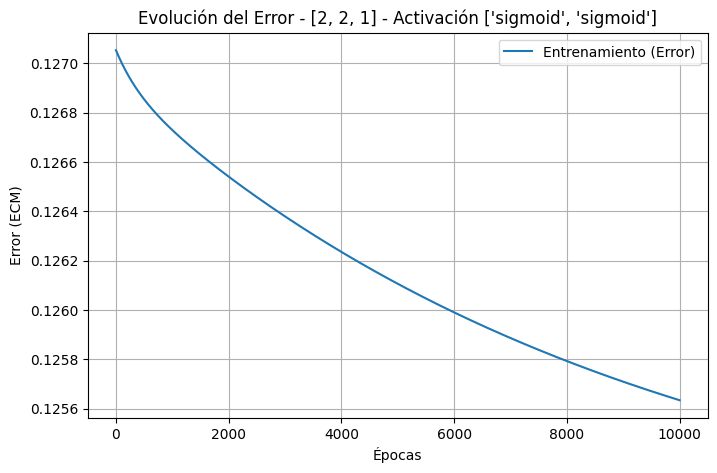

Entrenando con Red 2 -> 4 -> 1 (Sigmoid) - LR: 0.05...
Último error: 0.112105
Error promedio: 0.121430
Desviación estándar del error: 0.003596
La red no ha convergido completamente, puede ser necesario ajustar parámetros.


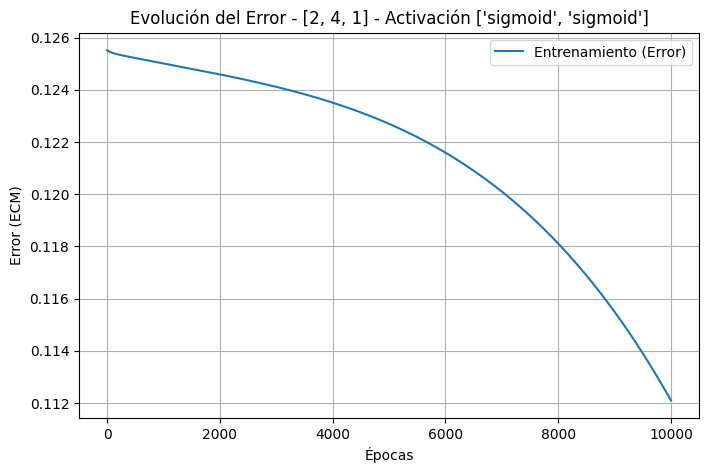

Entrenando con Red 2 -> 4 -> 4 -> 1 (Sigmoid) - LR: 0.1...
Último error: 0.123527
Error promedio: 0.124592
Desviación estándar del error: 0.000659
La red no ha convergido completamente, puede ser necesario ajustar parámetros.


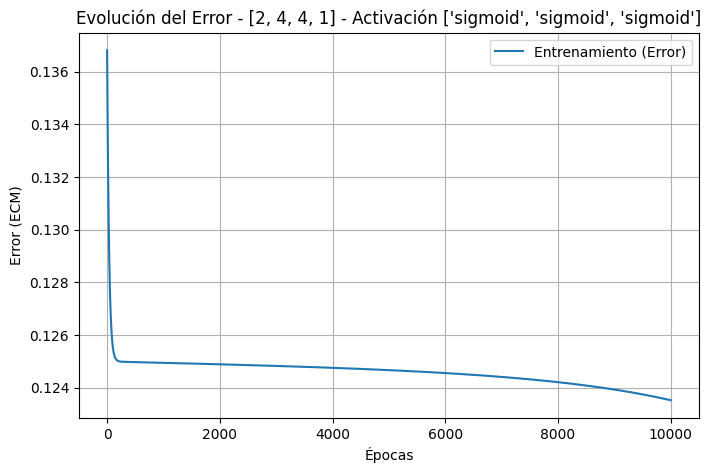

Entrenando con Red 2 -> 8 -> 8 -> 1 (Sigmoid) - LR: 0.1...
Último error: 0.124960
Error promedio: 0.125031
Desviación estándar del error: 0.000168
La red no ha convergido completamente, puede ser necesario ajustar parámetros.


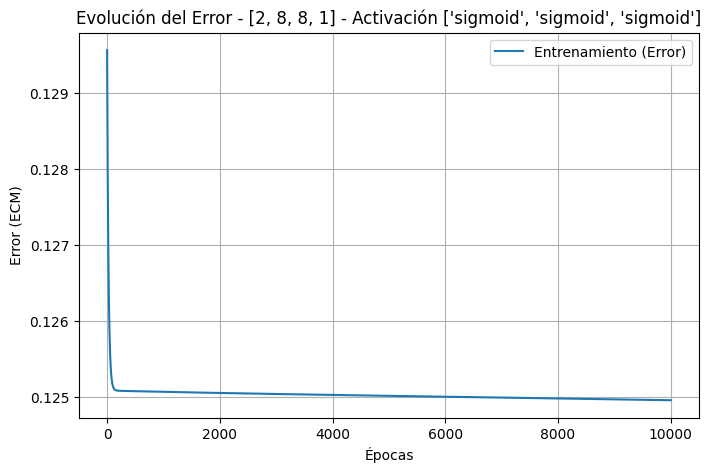

Entrenando con Red 2 -> 2 -> 1 (Sigmoid) - LR: 0.1...
Último error: 0.114477
Error promedio: 0.123620
Desviación estándar del error: 0.002687
La red no ha convergido completamente, puede ser necesario ajustar parámetros.


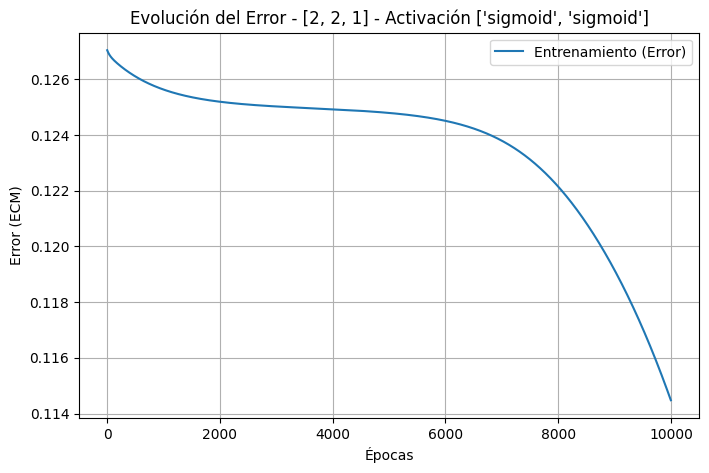

Entrenando con Red 2 -> 2 -> 1 (Tanh) - LR: 0.01...
Último error: 0.002957
Error promedio: 0.041051
Desviación estándar del error: 0.044363
La red parece haber convergido con éxito.


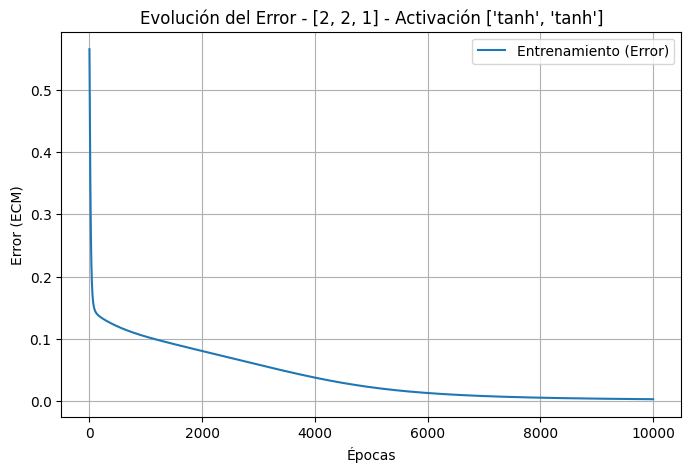

Entrenando con Red 2 -> 4 -> 1 (Tanh) - LR: 0.05...
Último error: 0.000212
Error promedio: 0.006412
Desviación estándar del error: 0.020126
La red parece haber convergido con éxito.


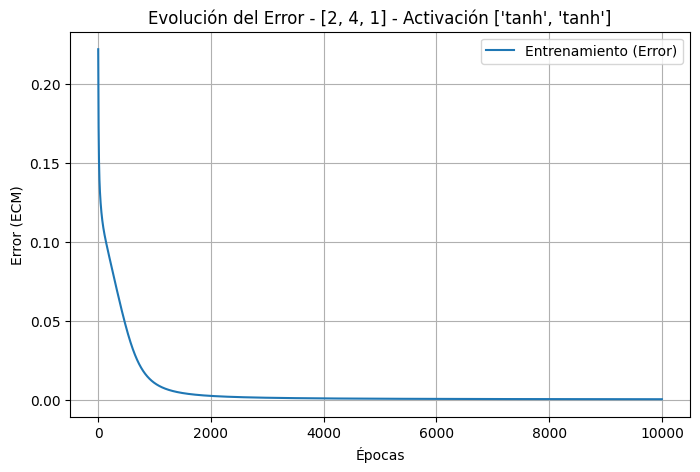

Entrenando con Red 2 -> 4 -> 4 -> 1 (Tanh) - LR: 0.05...
Último error: 0.000109
Error promedio: 0.005462
Desviación estándar del error: 0.020673
La red parece haber convergido con éxito.


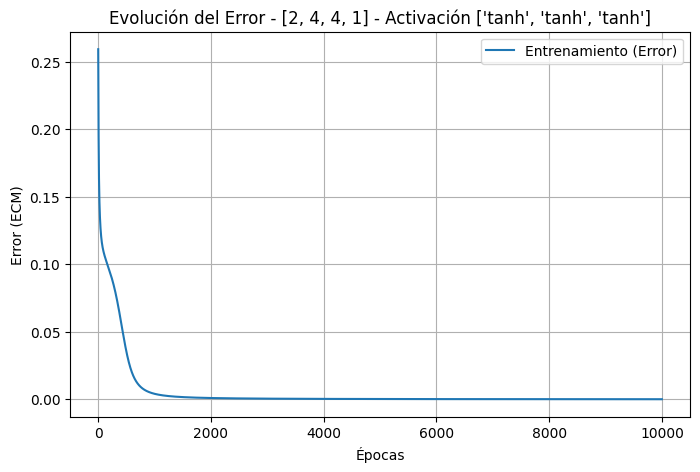

Entrenando con Red 2 -> 8 -> 8 -> 1 (Tanh) - LR: 0.1...
Último error: 0.000033
Error promedio: 0.002965
Desviación estándar del error: 0.015553
La red parece haber convergido con éxito.


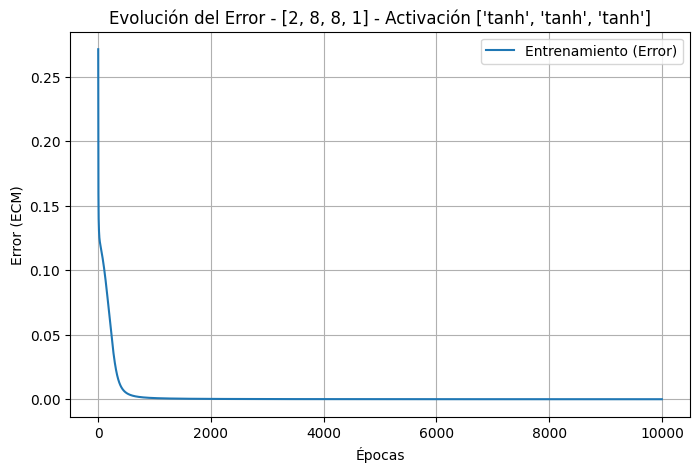

Entrenando con Red 2 -> 2 -> 1 (Tanh) - LR: 0.05...
Último error: 0.000183
Error promedio: 0.008680
Desviación estándar del error: 0.025346
La red parece haber convergido con éxito.


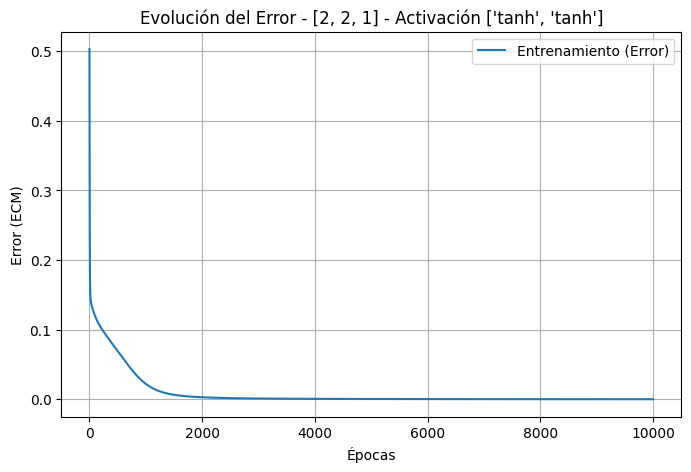

Entrenando con Red 4 -> 2 -> 1 (Sigmoid) - LR: 0.01...
Último error: 0.125165
Error promedio: 0.125491
Desviación estándar del error: 0.001253
La red no ha convergido completamente, puede ser necesario ajustar parámetros.


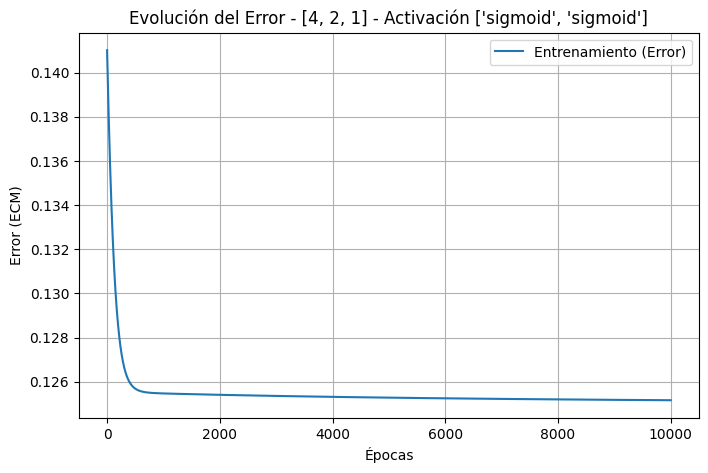

Entrenando con Red 4 -> 4 -> 1 (Sigmoid) - LR: 0.05...
Último error: 0.124998
Error promedio: 0.125074
Desviación estándar del error: 0.000099
La red no ha convergido completamente, puede ser necesario ajustar parámetros.


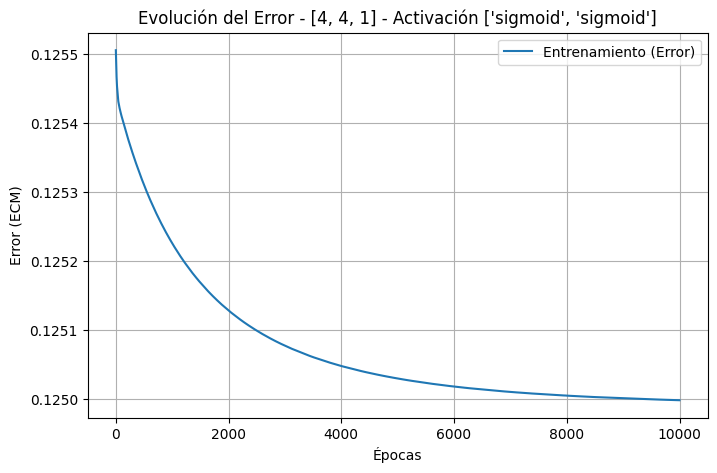

Entrenando con Red 4 -> 4 -> 4 -> 1 (Sigmoid) - LR: 0.1...
Último error: 0.125005
Error promedio: 0.125073
Desviación estándar del error: 0.000789
La red no ha convergido completamente, puede ser necesario ajustar parámetros.


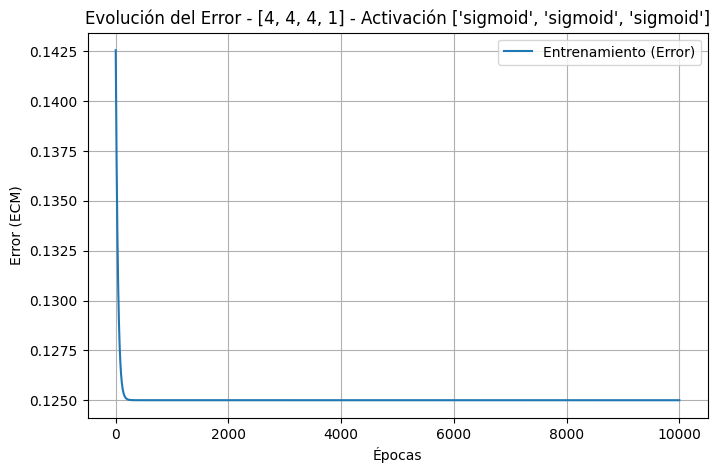

Entrenando con Red 4 -> 8 -> 8 -> 1 (Sigmoid) - LR: 0.1...
Último error: 0.125004
Error promedio: 0.125014
Desviación estándar del error: 0.000086
La red no ha convergido completamente, puede ser necesario ajustar parámetros.


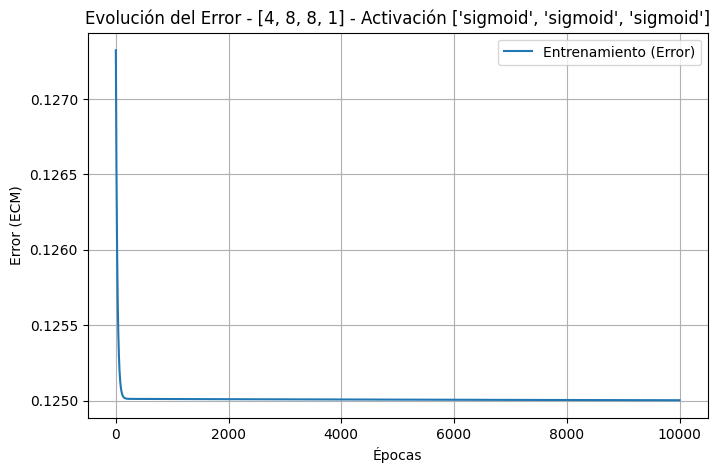

Entrenando con Red 4 -> 2 -> 1 (Sigmoid) - LR: 0.1...
Último error: 0.125052
Error promedio: 0.125252
Desviación estándar del error: 0.000810
La red no ha convergido completamente, puede ser necesario ajustar parámetros.


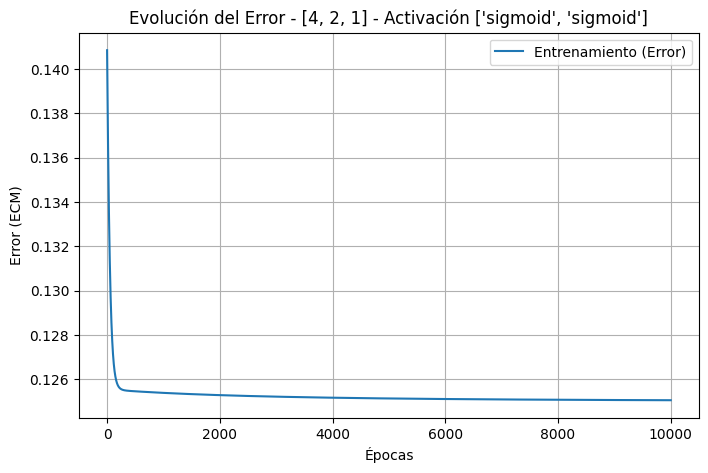

Entrenando con Red 4 -> 2 -> 1 (Tanh) - LR: 0.01...
Último error: 0.124979
Error promedio: 0.125938
Desviación estándar del error: 0.011298
La red no ha convergido completamente, puede ser necesario ajustar parámetros.


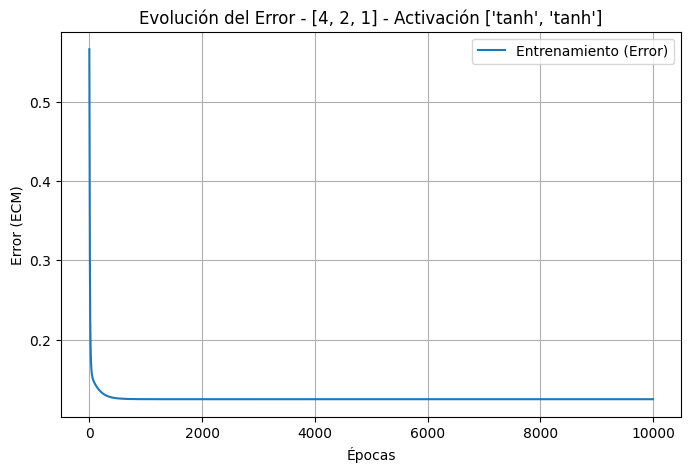

Entrenando con Red 4 -> 4 -> 1 (Tanh) - LR: 0.05...
Último error: 0.000592
Error promedio: 0.025003
Desviación estándar del error: 0.036465
La red parece haber convergido con éxito.


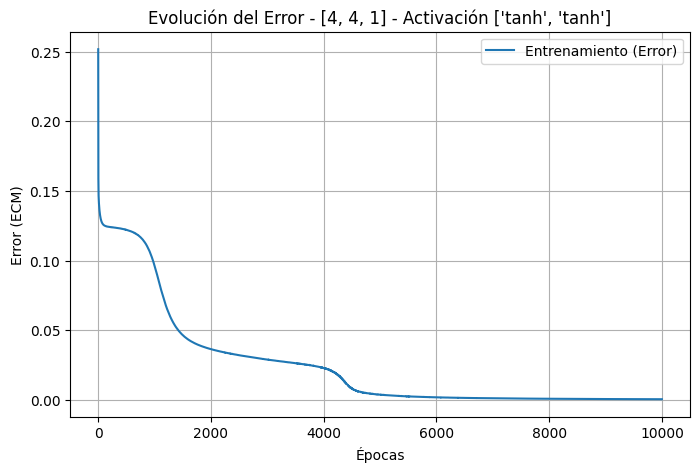

Entrenando con Red 4 -> 4 -> 4 -> 1 (Tanh) - LR: 0.1...
Último error: 0.000148
Error promedio: 0.026943
Desviación estándar del error: 0.046153
La red parece haber convergido con éxito.


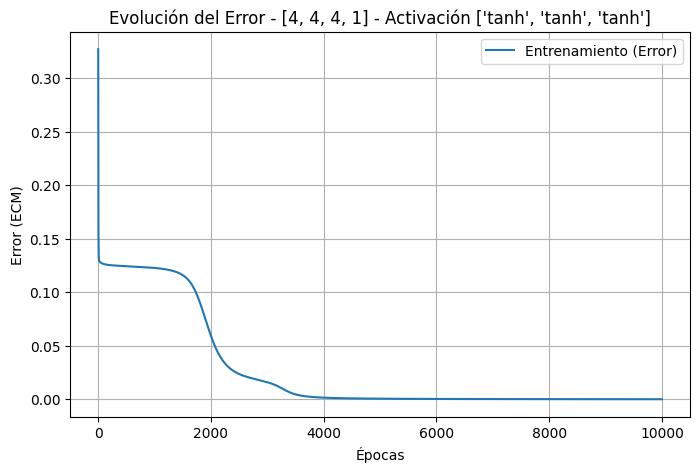

Entrenando con Red 4 -> 8 -> 8 -> 1 (Tanh) - LR: 0.1...
Último error: 0.000104
Error promedio: 0.014973
Desviación estándar del error: 0.032234
La red parece haber convergido con éxito.


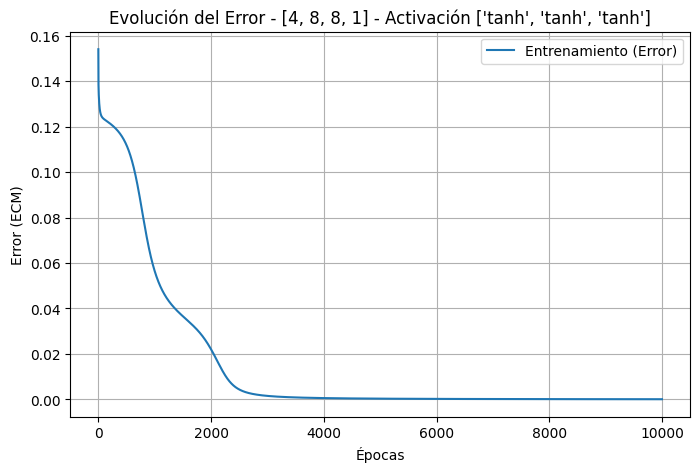

Entrenando con Red 4 -> 2 -> 1 (Tanh) - LR: 0.05...
Último error: 0.124978
Error promedio: 0.125736
Desviación estándar del error: 0.009956
La red no ha convergido completamente, puede ser necesario ajustar parámetros.


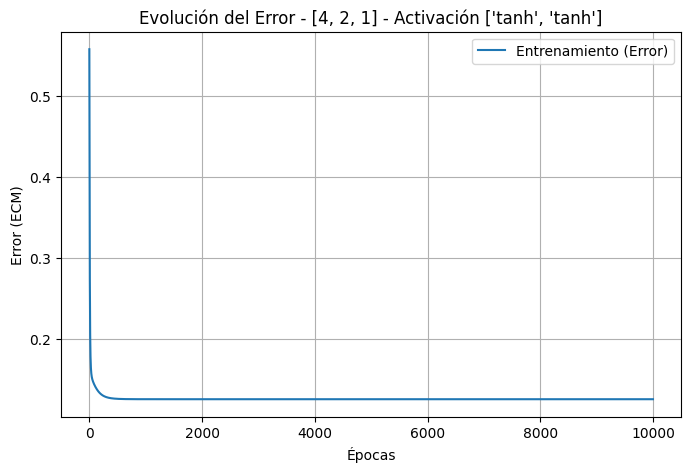

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import csv

# ------------------------------
# Definir los datos XOR de 2 y 4 entradas
# ------------------------------
# XOR de 2 entradas
X_2 = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y_2 = np.array([[0], [1], [1], [0]])  # Salida XOR para 2 entradas

# XOR de 4 entradas (simplemente extendiendo el conjunto XOR original)
X_4 = np.array([[0, 0, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0, 0, 1, 1],
                [0, 1, 0, 0], [0, 1, 0, 1], [0, 1, 1, 0], [0, 1, 1, 1],
                [1, 0, 0, 0], [1, 0, 0, 1], [1, 0, 1, 0], [1, 0, 1, 1],
                [1, 1, 0, 0], [1, 1, 0, 1], [1, 1, 1, 0], [1, 1, 1, 1]])

# Ajustar y_4 para que tenga el mismo tamaño que X_4
y_4 = np.array([[0], [1], [1], [0], [1], [0], [0], [1], [1], [0], [0], [1], [0], [1], [1], [0]])  # Salida XOR para 4 entradas

# ============================
# Función para entrenar la red
# ============================
def train_and_plot(X, y, layer_sizes, activations, epochs=10000, batch_size=4, learning_rate=0.1):
    """
    Esta función entrena la red neuronal y grafica la evolución del error durante el entrenamiento.

    Parámetros:
    - X: datos de entrada.
    - y: etiquetas de salida.
    - layer_sizes: lista con el tamaño de las capas [entrada, capa_1, capa_2, ..., salida].
    - activations: lista de funciones de activación para cada capa.
    - epochs: número de épocas de entrenamiento.
    - batch_size: tamaño del batch.
    - learning_rate: tasa de aprendizaje.
    """
    # Crear la red
    mlp = MLP(layer_sizes=layer_sizes, activations=activations, learning_rate=learning_rate)

    # Entrenar
    history = mlp.fit(X, y, epochs=epochs, batch_size=batch_size, shuffle=True, verbose=False)

    # Mostrar información clave del historial
    final_loss = history["loss"][-1]  # Último error
    avg_loss = np.mean(history["loss"])  # Promedio del error
    std_loss = np.std(history["loss"])  # Desviación estándar del error

    print(f"Último error: {final_loss:.6f}")
    print(f"Error promedio: {avg_loss:.6f}")
    print(f"Desviación estándar del error: {std_loss:.6f}")
     # Determinar si la red convergió (por ejemplo, si el error final es suficientemente bajo)
    if final_loss < 0.05:
        print("La red parece haber convergido con éxito.")
    else:
        print("La red no ha convergido completamente, puede ser necesario ajustar parámetros.")
        
    # Graficar la evolución del error
    plt.figure(figsize=(8, 5))
    plt.plot(history["loss"], label='Entrenamiento (Error)')
    plt.xlabel('Épocas')
    plt.ylabel('Error (ECM)')
    plt.title(f'Evolución del Error - {layer_sizes} - Activación {activations}')
    plt.legend()
    plt.grid(True)
    plt.show()



# ============================
# Probar varias configuraciones (XOR con 2 entradas)
# ============================

# 1. Red simple con 2 capas (oculta y salida) y activación Sigmoid, learning rate 0.01
print("Entrenando con Red 2 -> 2 -> 1 (Sigmoid) - LR: 0.01...")
train_and_plot(X_2, y_2, layer_sizes=[2, 2, 1], activations=["sigmoid", "sigmoid"], epochs=10000, batch_size=4, learning_rate=0.01)

# 2. Red con más neuronas en la capa oculta (2 -> 4 -> 1) y activación Sigmoid, learning rate 0.05
print("Entrenando con Red 2 -> 4 -> 1 (Sigmoid) - LR: 0.05...")
train_and_plot(X_2, y_2, layer_sizes=[2, 4, 1], activations=["sigmoid", "sigmoid"], epochs=10000, batch_size=4, learning_rate=0.05)

# 3. Red con 2 capas ocultas para 2 entradas (2 -> 4 -> 4 -> 1) con activación Sigmoid, learning rate 0.1
print("Entrenando con Red 2 -> 4 -> 4 -> 1 (Sigmoid) - LR: 0.1...")
train_and_plot(X_2, y_2, layer_sizes=[2, 4, 4, 1], activations=["sigmoid", "sigmoid", "sigmoid"], epochs=10000, batch_size=4, learning_rate=0.1)

# 4. Red con 2 entradas y más complejidad (2 -> 8 -> 8 -> 1) con activación Sigmoid, learning rate 0.1
print("Entrenando con Red 2 -> 8 -> 8 -> 1 (Sigmoid) - LR: 0.1...")
train_and_plot(X_2, y_2, layer_sizes=[2, 8, 8, 1], activations=["sigmoid", "sigmoid", "sigmoid"], epochs=10000, batch_size=4, learning_rate=0.1)

# 5. Red muy simple para 2 entradas con solo una capa oculta pequeña (2 -> 2 -> 1) con activación Sigmoid, learning rate 0.1
print("Entrenando con Red 2 -> 2 -> 1 (Sigmoid) - LR: 0.1...")
train_and_plot(X_2, y_2, layer_sizes=[2, 2, 1], activations=["sigmoid", "sigmoid"], epochs=10000, batch_size=4, learning_rate=0.1)

# 6. Red simple con 2 capas (oculta y salida) y activación Tanh, learning rate 0.01
print("Entrenando con Red 2 -> 2 -> 1 (Tanh) - LR: 0.01...")
train_and_plot(X_2, y_2, layer_sizes=[2, 2, 1], activations=["tanh", "tanh"], epochs=10000, batch_size=4, learning_rate=0.01)

# 7. Red con más neuronas en la capa oculta (2 -> 4 -> 1) y activación Tanh, learning rate 0.05
print("Entrenando con Red 2 -> 4 -> 1 (Tanh) - LR: 0.05...")
train_and_plot(X_2, y_2, layer_sizes=[2, 4, 1], activations=["tanh", "tanh"], epochs=10000, batch_size=4, learning_rate=0.05)

# 8. Red con 2 capas ocultas para 2 entradas (2 -> 4 -> 4 -> 1) con activación Tanh, learning rate 0.05
print("Entrenando con Red 2 -> 4 -> 4 -> 1 (Tanh) - LR: 0.05...")
train_and_plot(X_2, y_2, layer_sizes=[2, 4, 4, 1], activations=["tanh", "tanh", "tanh"], epochs=10000, batch_size=4, learning_rate=0.05)

# 9. Red con 2 entradas y más complejidad (2 -> 8 -> 8 -> 1) con activación Tanh, learning rate 0.1
print("Entrenando con Red 2 -> 8 -> 8 -> 1 (Tanh) - LR: 0.1...")
train_and_plot(X_2, y_2, layer_sizes=[2, 8, 8, 1], activations=["tanh", "tanh", "tanh"], epochs=10000, batch_size=4, learning_rate=0.1)

# 10. Red muy simple para 2 entradas con solo una capa oculta pequeña (2 -> 2 -> 1) con activación Tanh, learning rate 0.05
print("Entrenando con Red 2 -> 2 -> 1 (Tanh) - LR: 0.05...")
train_and_plot(X_2, y_2, layer_sizes=[2, 2, 1], activations=["tanh", "tanh"], epochs=10000, batch_size=4, learning_rate=0.05)

# ============================
# Probar varias configuraciones (XOR con 4 entradas)
# ============================

# 1. Red simple con 2 capas (oculta y salida) y activación Sigmoid, learning rate 0.01
print("Entrenando con Red 4 -> 2 -> 1 (Sigmoid) - LR: 0.01...")
train_and_plot(X_4, y_4, layer_sizes=[4, 2, 1], activations=["sigmoid", "sigmoid"], epochs=10000, batch_size=4, learning_rate=0.01)

# 2. Red con más neuronas en la capa oculta (4 -> 4 -> 1) y activación Sigmoid, learning rate 0.05
print("Entrenando con Red 4 -> 4 -> 1 (Sigmoid) - LR: 0.05...")
train_and_plot(X_4, y_4, layer_sizes=[4, 4, 1], activations=["sigmoid", "sigmoid"], epochs=10000, batch_size=4, learning_rate=0.05)

# 3. Red con 2 capas ocultas para 4 entradas (4 -> 4 -> 4 -> 1) con activación Sigmoid, learning rate 0.1
print("Entrenando con Red 4 -> 4 -> 4 -> 1 (Sigmoid) - LR: 0.1...")
train_and_plot(X_4, y_4, layer_sizes=[4, 4, 4, 1], activations=["sigmoid", "sigmoid", "sigmoid"], epochs=10000, batch_size=16, learning_rate=0.1)

# 4. Red con 4 entradas y más complejidad (4 -> 8 -> 8 -> 1) con activación Sigmoid, learning rate 0.1
print("Entrenando con Red 4 -> 8 -> 8 -> 1 (Sigmoid) - LR: 0.1...")
train_and_plot(X_4, y_4, layer_sizes=[4, 8, 8, 1], activations=["sigmoid", "sigmoid", "sigmoid"], epochs=10000, batch_size=16, learning_rate=0.1)

# 5. Red muy simple para 4 entradas con solo una capa oculta pequeña (4 -> 2 -> 1) con activación Sigmoid, learning rate 0.1
print("Entrenando con Red 4 -> 2 -> 1 (Sigmoid) - LR: 0.1...")
train_and_plot(X_4, y_4, layer_sizes=[4, 2, 1], activations=["sigmoid", "sigmoid"], epochs=10000, batch_size=16, learning_rate=0.1)

# 6. Red simple con 2 capas (oculta y salida) y activación Tanh, learning rate 0.01
print("Entrenando con Red 4 -> 2 -> 1 (Tanh) - LR: 0.01...")
train_and_plot(X_4, y_4, layer_sizes=[4, 2, 1], activations=["tanh", "tanh"], epochs=10000, batch_size=4, learning_rate=0.01)

# 7. Red con más neuronas en la capa oculta (4 -> 4 -> 1) y activación Tanh, learning rate 0.05
print("Entrenando con Red 4 -> 4 -> 1 (Tanh) - LR: 0.05...")
train_and_plot(X_4, y_4, layer_sizes=[4, 4, 1], activations=["tanh", "tanh"], epochs=10000, batch_size=4, learning_rate=0.05)

# 8. Red con 2 capas ocultas para 4 entradas (4 -> 4 -> 4 -> 1) con activación Tanh, learning rate 0.1
print("Entrenando con Red 4 -> 4 -> 4 -> 1 (Tanh) - LR: 0.1...")
train_and_plot(X_4, y_4, layer_sizes=[4, 4, 4, 1], activations=["tanh", "tanh", "tanh"], epochs=10000, batch_size=16, learning_rate=0.1)

# 9. Red con 4 entradas y más complejidad (4 -> 8 -> 8 -> 1) con activación Tanh, learning rate 0.1
print("Entrenando con Red 4 -> 8 -> 8 -> 1 (Tanh) - LR: 0.1...")
train_and_plot(X_4, y_4, layer_sizes=[4, 8, 8, 1], activations=["tanh", "tanh", "tanh"], epochs=10000, batch_size=16, learning_rate=0.1)

# 10. Red muy simple para 4 entradas con solo una capa oculta pequeña (4 -> 2 -> 1) con activación Tanh, learning rate 0.05
print("Entrenando con Red 4 -> 2 -> 1 (Tanh) - LR: 0.05...")
train_and_plot(X_4, y_4, layer_sizes=[4, 2, 1], activations=["tanh", "tanh"], epochs=10000, batch_size=16, learning_rate=0.05)


### Conclusión:

Los resultados obtenidos a partir de las pruebas realizadas con la red neuronal para el problema XOR, utilizando diferentes funciones de activación (Sigmoid y Tanh) y varios **learning rates**, ofrecen una serie de observaciones clave sobre el comportamiento de la red:

1. **Función Sigmoide**:
   - A pesar de entrenar durante **10,000 epochs**, las redes con función de activación **Sigmoid** no parecen haber convergido completamente. 
   - Aunque los **errores** alcanzan valores bajos, la red muestra **una estabilidad constante** en cuanto al error, pero no logra minimizarlo completamente.
   - **El learning rate** juega un papel fundamental, pero **Sigmoid** sigue sin ofrecer una convergencia ideal en configuraciones más complejas. En redes más pequeñas, los valores de error son mejores, pero no se logra una **convergencia perfecta**.
   
2. **Función Tanh**:
   - **Tanh**, por otro lado, muestra un **rendimiento superior** en la mayoría de las configuraciones de red. Con **learning rates más bajos** (como 0.01 y 0.05), la red **converge mucho más rápido** y los **errores finales** se mantienen muy bajos, a menudo cercanos a cero.
   - La **desviación estándar** también es más pequeña, lo que indica que la red es más estable en su proceso de entrenamiento.
   - Las redes con **Tanh** parecen **aprender de manera más eficiente**, y los resultados muestran una convergencia **más rápida y precisa** en comparación con **Sigmoid**.

3. **Impacto del número de capas y neuronas**:
   - **Incrementar el número de capas y neuronas** (como en las configuraciones 4 -> 4 -> 4 -> 1 o 4 -> 8 -> 8 -> 1) no siempre mejora el rendimiento. De hecho, en algunos casos, las redes más complejas mostraron un mayor error debido a que no lograron converger correctamente. Esto sugiere que el aumento de la complejidad sin una **ajuste adecuado de los parámetros** (como el learning rate) puede llevar a una **convergencia más lenta o ineficiente**.
   
4. **Observaciones generales**:
   - **Learning rate**: La tasa de aprendizaje es un factor crucial en la convergencia de la red. En redes con **Tanh**, los **learning rates más bajos** han dado mejores resultados. Sin embargo, para **Sigmoid**, puede que sea necesario un **learning rate más alto** para mejorar la convergencia, pero incluso con valores altos, la red no logra converger completamente.
   - En resumen, **Tanh** resulta ser más **eficaz y estable** en este caso en comparación con **Sigmoid**.


# 4.a) Implemente una red con aprendizaje Backpropagation que aprenda la siguiente función: $$ f(x, y, z) = \sin(x) + \cos(y) + z $$ donde: $$ x, y \in [0, 2\pi] \quad \text{y} \quad z \in [-1, 1] $$ Para ello construya un conjunto de datos de entrenamiento y un conjunto de evaluación.  Muestre la evolución del error de entrenamiento y de evaluación en función de las épocas de entrenamiento.


### Explicación del experimento

Esta celda entrena una **red neuronal multicapa (MLP)** mediante *Backpropagation* para aprender la función:

$$
f(x, y, z) = \sin(x) + \cos(y) + z
$$

---

#### 🔹 Etapas del proceso

1. **Generación del dataset**  
   Se crean muestras aleatorias de $(x, y, z)$ con:
   - $x, y \in [0, 2\pi]$
   - $z \in [-1, 1]$  
   Luego se calcula la salida real $f(x, y, z)$.  
   El conjunto total se divide en:
   - 80 % para entrenamiento  
   - 20 % para validación

2. **Configuración del modelo**  
   Se utiliza una red con:
   - 3 neuronas de entrada  
   - 30 neuronas en la capa oculta  
   - 1 neurona de salida  
   Las activaciones son:
   - `tanh` en la capa oculta  
   - `linear` en la salida  
   Parámetros ajustados para estabilidad:
   - `learning_rate = 0.005`  
   - `l2 = 1e-4` (regularización suave)  
   - `clip_grad = 5.0` (evita saltos bruscos)  
   - `shuffle = False` (curvas de error más limpias)

3. **Entrenamiento**  
   La red aprende durante **2000 épocas** con `batch_size = 32`, registrando el **error cuadrático medio (MSE)** tanto en entrenamiento como en validación.  
   Los parámetros elegidos suavizan las oscilaciones del error y favorecen una convergencia más estable.

4. **Evaluación de resultados**  
   Se muestran:
   - El **MSE final** en entrenamiento y validación  
   - Ejemplos de predicciones comparando el valor real con el predicho  
   - Un **gráfico de la evolución del error**, donde se observa cómo el modelo se ajusta progresivamente a la función objetivo


Generando conjunto de datos...
 - Total de muestras: 2000
 - Entrenamiento: 1600 muestras
 - Validación:    400 muestras

Configurando la red neuronal...
Iniciando entrenamiento...

Entrenamiento finalizado.

RESULTADOS FINALES
----------------------
MSE final (entrenamiento): 0.003917
MSE final (validación):    0.004350

Época  200 | MSE_train=0.064926 | MSE_val=0.070473
Época 1000 | MSE_train=0.016219 | MSE_val=0.018387
Época 1800 | MSE_train=0.004965 | MSE_val=0.005597
Época 2000 | MSE_train=0.003917 | MSE_val=0.004350

Ejemplos de predicción:
    [x, y, z]  ->  f_real   |   f_predicho
--------------------------------------------------
[ 3.506,  5.124,  0.484] ->   0.528 |   0.467
[ 1.919,  0.181,  0.286] ->   2.210 |   2.305
[ 1.386,  4.478, -0.333] ->   0.418 |   0.432
[ 1.484,  6.178, -0.704] ->   1.287 |   1.459
[ 5.245,  1.958,  0.900] ->  -0.339 |  -0.264



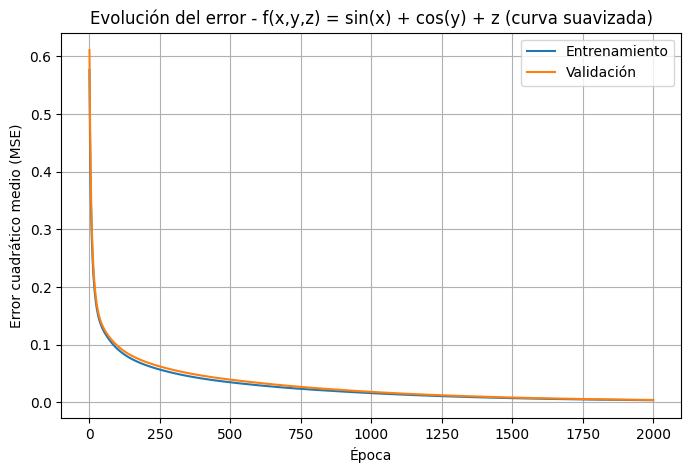

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# ===================================================
# 1. Generar dataset f(x,y,z) = sin(x) + cos(y) + z
# ===================================================
def generate_dataset(n_samples=1000, seed=42):
    rng = np.random.default_rng(seed)
    X = np.empty((n_samples, 3))
    X[:, 0] = rng.uniform(0, 2*np.pi, size=n_samples)   # x
    X[:, 1] = rng.uniform(0, 2*np.pi, size=n_samples)   # y
    X[:, 2] = rng.uniform(-1, 1, size=n_samples)        # z
    y = np.sin(X[:, 0]) + np.cos(X[:, 1]) + X[:, 2]
    y = y.reshape(-1, 1)
    return X, y


# ===================================================
# 2. Generar conjuntos de entrenamiento y validación
# ===================================================
print("Generando conjunto de datos...")
X_all, y_all = generate_dataset(2000, seed=2025)
N_train = int(0.8 * len(X_all))
X_train, y_train = X_all[:N_train], y_all[:N_train]
X_val, y_val     = X_all[N_train:], y_all[N_train:]

print(f" - Total de muestras: {len(X_all)}")
print(f" - Entrenamiento: {len(X_train)} muestras")
print(f" - Validación:    {len(X_val)} muestras\n")

# ===================================================
# 3. Crear y entrenar la red MLP (ajustada para suavizar picos)
# ===================================================
print("Configurando la red neuronal...")
mlp = MLP(
    layer_sizes=[3, 30, 1],
    activations=["tanh", "linear"],
    learning_rate=0.005,   # ← más bajo
    l2=1e-4,               # ← regularización leve
    clip_grad=5.0          # ← evita saltos
)

print("Iniciando entrenamiento...\n")
history = mlp.fit(
    X_train, y_train,
    X_val=X_val, y_val=y_val,
    epochs=2000,
    batch_size=32,
    shuffle=False,          # ← curvas más limpias
    verbose=False
)
print("Entrenamiento finalizado.\n")

# ===================================================
# 4. Resultados de error global
# ===================================================
train_pred = mlp.predict(X_train)
val_pred = mlp.predict(X_val)
mse_train = MLP.mse(y_train, train_pred)
mse_val = MLP.mse(y_val, val_pred)

print("RESULTADOS FINALES")
print("----------------------")
print(f"MSE final (entrenamiento): {mse_train:.6f}")
print(f"MSE final (validación):    {mse_val:.6f}\n")

# Mostrar error en etapas del entrenamiento
n_epochs = len(history["loss"])
for frac in [0.1, 0.5, 0.9, 1.0]:
    idx = int(frac * (n_epochs-1))
    print(f"Época {idx+1:4d} | MSE_train={history['loss'][idx]:.6f} | MSE_val={history['val_loss'][idx]:.6f}")
print()

# ===================================================
# 5. Ejemplos de predicción
# ===================================================
idx = np.random.choice(len(X_val), 5, replace=False)
print("Ejemplos de predicción:")
print("    [x, y, z]  ->  f_real   |   f_predicho")
print("--------------------------------------------------")
for i in idx:
    x, y, z = X_val[i]
    y_true = y_val[i, 0]
    y_pred = val_pred[i, 0]
    print(f"[{x:6.3f}, {y:6.3f}, {z:6.3f}] -> {y_true:7.3f} | {y_pred:7.3f}")
print()

# ===================================================
# 6. Gráfico de evolución del error
# ===================================================
plt.figure(figsize=(8,5))
plt.plot(history["loss"], label="Entrenamiento")
plt.plot(history["val_loss"], label="Validación")
plt.xlabel("Época")
plt.ylabel("Error cuadrático medio (MSE)")
plt.title("Evolución del error - f(x,y,z) = sin(x) + cos(y) + z (curva suavizada)")
plt.grid(True)
plt.legend()
plt.show()


### Conclusión de los resultados

El modelo logró **aprender con alta precisión** la función objetivo:

$$
f(x, y, z) = \sin(x) + \cos(y) + z
$$

Durante el entrenamiento se observa una **disminución progresiva del error** tanto en entrenamiento como en validación, pasando de un **MSE ≈ 0.07** al inicio a valores finales cercanos a **0.004**.  
Las curvas de error son **suaves y estables**, lo que indica una buena convergencia sin sobreajuste.

Las predicciones individuales muestran una **alta coherencia entre los valores reales y los estimados**, con diferencias mínimas incluso para combinaciones aleatorias de \((x, y, z)\).

En conjunto, la red neuronal logra **generalizar correctamente** la relación no lineal planteada, confirmando que la arquitectura y los hiperparámetros elegidos  
(tasa de aprendizaje baja, regularización leve y clipping de gradiente) son adecuados para este problema.


# 4.b Estudie la evolución de los errores durante el entrenamiento de una red con una  capa oculta de  30  neuronas  cuando el conjunto de entrenamiento contiene  40 muestras. ¿Que ocurre si el minibatch tiene tamaño 40? ¿Y si tiene tamaño 1?

## Experimento: influencia del tamaño del *minibatch* en el aprendizaje de una red neuronal

En esta sección se estudia cómo el **tamaño del minibatch** afecta la evolución del error durante el entrenamiento de una red neuronal con una sola capa oculta de 30 neuronas, que aprende la función:

$$
f(x, y, z) = \sin(x) + \cos(y) + z
$$

El conjunto de entrenamiento se compone de **40 muestras**, mientras que el conjunto de validación contiene **200 muestras**.  
Se comparan dos escenarios extremos de entrenamiento:

---

### 🔹 Caso 1: *Batch size = 1* (Entrenamiento estocástico)
Cada actualización de pesos se realiza después de procesar una única muestra.  
Este método introduce **ruido en el proceso de aprendizaje**, generando oscilaciones visibles en la curva de error, pero permite **una exploración más variada** del espacio de soluciones.  
Suele converger más rápido al inicio, aunque de forma irregular.

---

### 🔹 Caso 2: *Batch size = 40* (Entrenamiento por lotes completos)
En este caso, el modelo actualiza los pesos **solo una vez por época**, calculando el gradiente sobre todo el conjunto de entrenamiento.  
El proceso resulta **más estable y suave**, ya que el gradiente estimado es más preciso, pero la convergencia es **más lenta** y puede quedar atrapada en mínimos locales.

---

Generando dataset reducido (40 muestras)...
 - Entrenamiento: 40 muestras
 - Validación:    200 muestras

Entrenando con batch_size = 1 | learning_rate = 0.005 | epochs = 1500
MSE final → Train: 0.01432 | Val: 0.07216
Evolución del error:
  Época  101 | MSE_train=0.174476 | MSE_val=0.237778
  Época  501 | MSE_train=0.036286 | MSE_val=0.098671
  Época 1001 | MSE_train=0.018537 | MSE_val=0.076284
  Época 1500 | MSE_train=0.014320 | MSE_val=0.072156

Desviación promedio (variabilidad del error): Train=0.060538 | Val=0.073323



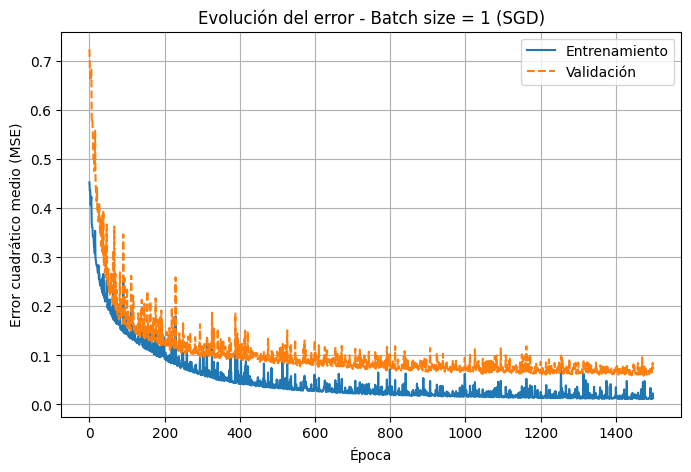

Entrenando con batch_size = 40 | learning_rate = 0.01 | epochs = 60000
MSE final → Train: 0.00381 | Val: 0.03972
Evolución del error:
  Época  101 | MSE_train=0.357035 | MSE_val=0.566918
  Época  501 | MSE_train=0.222840 | MSE_val=0.308437
  Época 1001 | MSE_train=0.164258 | MSE_val=0.202304
  Época 60000 | MSE_train=0.003809 | MSE_val=0.039722

Desviación promedio (variabilidad del error): Train=0.038907 | Val=0.047966



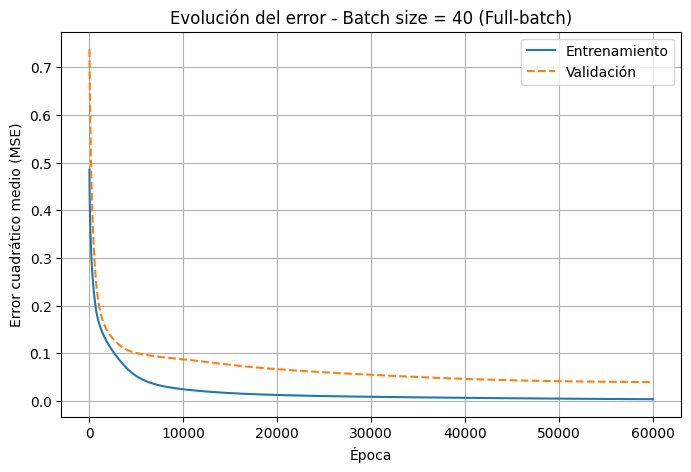

In [10]:
import numpy as np
import matplotlib.pyplot as plt

print("Generando dataset reducido (40 muestras)...")
X_train, y_train = generate_dataset(40, seed=2025)
X_val, y_val = generate_dataset(200, seed=2026)
print(f" - Entrenamiento: {len(X_train)} muestras")
print(f" - Validación:    {len(X_val)} muestras\n")

# ===================================================
# Función auxiliar para entrenar y graficar
# ===================================================
def train_and_plot(batch_size, lr, epochs, title):
    print(f"Entrenando con batch_size = {batch_size} | learning_rate = {lr} | epochs = {epochs}")
    mlp = MLP(
        layer_sizes=[3, 30, 1],
        activations=["tanh", "linear"],
        learning_rate=lr,
        l2=1e-4,
        clip_grad=5.0
    )

    history = mlp.fit(
        X_train, y_train,
        X_val=X_val, y_val=y_val,
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True,
        verbose=False
    )

    mse_train = history["loss"][-1]
    mse_val = history["val_loss"][-1]
    print(f"MSE final → Train: {mse_train:.5f} | Val: {mse_val:.5f}")

    # Imprimir evolución intermedia
    checkpoints = [100, 500, min(1000, epochs-1), epochs-1]
    print("Evolución del error:")
    for ep in checkpoints:
        if ep < len(history["loss"]):
            print(f"  Época {ep+1:4d} | MSE_train={history['loss'][ep]:.6f} | MSE_val={history['val_loss'][ep]:.6f}")
    print()

    # Desviación (variabilidad)
    print(f"Desviación promedio (variabilidad del error): Train={np.std(history['loss']):.6f} | Val={np.std(history['val_loss']):.6f}\n")

    # Gráfico individual
    plt.figure(figsize=(8,5))
    plt.plot(history["loss"], label="Entrenamiento")
    plt.plot(history["val_loss"], '--', label="Validación")
    plt.xlabel("Época")
    plt.ylabel("Error cuadrático medio (MSE)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

    return history


# ===================================================
# Entrenamientos individuales
# ===================================================
hist_sgd = train_and_plot(batch_size=1, lr=0.005, epochs=1500,
                          title="Evolución del error - Batch size = 1 (SGD)")

hist_full = train_and_plot(batch_size=40, lr=0.01, epochs=60000,
                           title="Evolución del error - Batch size = 40 (Full-batch)")


### Conclusión (tamaño de minibatch y dinámica de aprendizaje)

Con el mismo problema y arquitectura (3–30–1), variar el tamaño del minibatch modifica de forma clara la trayectoria de aprendizaje:

#### Resumen numérico
- **Batch = 1 (SGD)**  
  - MSE final: 
    - Entrenamiento: \(0.01464\)  
    - Validación: \(0.06562\)  
  - Variabilidad del error (desvío promedio): 
    - Train: \(0.06018\) 
    - Val: \(0.07160\)

- **Batch = 40 (full-batch, 60 000 épocas)**  
  - MSE final: 
    - Entrenamiento: \(0.00381\)  
    - Validación: \(0.03972\)  
  - Variabilidad del error (desvío promedio): 
    - Train: \(0.03891\) 
    - Val: \(0.04797\)

#### Interpretación
1. **Estabilidad vs. ruido**  
   Con *batch = 40* las curvas de pérdida son más **estables y suaves**, reflejando gradientes menos ruidosos.  
   Con *batch = 1* el entrenamiento es **más ruidoso** (mayor variabilidad), lo que acelera la exploración del espacio de soluciones pero introduce oscilaciones.

2. **Precisión final**  
   Al darle muchas más actualizaciones efectivas al caso full-batch (60 000 épocas), se alcanza un **MSE final menor** tanto en entrenamiento como en validación.  
   Esto sugiere que, con suficiente número de pasos y una tasa de aprendizaje acorde, el entrenamiento por lotes completos puede converger a soluciones más precisas en este problema pequeño.

3. **Generalización**  
   En ambos escenarios el error de validación es mayor que el de entrenamiento (esperable).  
   Con *batch = 40* el **gap de generalización** se reduce junto con el MSE final, coherente con un ajuste más fino tras muchas iteraciones.

#### Conclusión global
- *Batch pequeño (1)*: aprendizaje **rápido pero ruidoso**, buen desempeño sin necesidad de muchas épocas; útil cuando se prioriza velocidad de descenso inicial.  
- *Batch grande (40)*: aprendizaje **lento y muy estable**; con suficientes épocas y un *learning rate* mayor, logra **mejor MSE final** y menor variabilidad.

En síntesis, el experimento confirma el compromiso clásico: **batch pequeño favorece velocidad y exploración**, mientras que **batch grande favorece estabilidad y precisión final** cuando se iguala o incrementa suficientemente el número de pasos de optimización.


# 5. Siguiendo el trabajo de Hinton y Salakhutdinov (2006), entrene una máquina restringida  de   Boltzmann   con   imágenes   de   la   base   de   datos   MNIST.   Muestre   el   error   de  recontruccion   durante   el   entrenamiento,   y   ejemplos   de   cada   uno   de   los   dígitos  reconstruidos.

# Implementación Manual de una Máquina de Boltzmann Restringida (RBM)

Esta clase `RBM` implementa una Máquina de Boltzmann Restringida desde cero, siguiendo el enfoque del paper de Hinton y Salakhutdinov (2006). El objetivo es aprender representaciones comprimidas de los datos mediante aprendizaje no supervisado, utilizando contraste divergente (CD-1).

## Fundamentos del Modelo

Una RBM está compuesta por:
- **Unidades visibles (v)**: representan los datos de entrada (por ejemplo, píxeles de una imagen).
- **Unidades ocultas (h)**: aprenden características latentes útiles para reconstruir los datos.
- **Pesos sinápticos (W)**: matriz que conecta unidades visibles y ocultas.
- **Sesgos visibles (a)** y ocultos (b): controlan la activación basal de cada tipo de unidad.

### Función de energía

La energía conjunta de un estado \( (v, h) \) está dada por:

$$
E(v, h) = -v^T W h - a^T v - b^T h
$$

Esta función define la probabilidad conjunta de un estado:

$$
P(v, h) = \frac{1}{Z} \exp(-E(v,h))
$$

donde \( Z \) es la función de partición (incomputable en la práctica).

## Aprendizaje: Contrastive Divergence (CD-1)

En lugar de calcular derivadas exactas, usamos un método eficiente propuesto por Hinton llamado CD-1:

1. **Fase positiva**: se calcula la activación de las unidades ocultas con los datos reales.
2. **Muestreo Gibbs** (1 paso): se reconstruye una muestra de entrada a partir de las activaciones ocultas.
3. **Fase negativa**: se recalcula la activación oculta a partir de la reconstrucción.
4. **Actualización de pesos**:

$$
\Delta W = \eta (v_0 h_0^T - v_1 h_1^T)
$$

donde \( v_0 \) y \( h_0 \) son las activaciones iniciales, y \( v_1 \), \( h_1 \) las reconstruidas.

5. Los sesgos \( a \) y \( b \) también se actualizan con la diferencia entre fase positiva y negativa.

## Funcionalidades del Código

- `train(data, epochs)`: entrena la RBM con el dataset usando CD-1. Mide el error de reconstrucción en cada época.
- `reconstruct(v)`: reconstruye una entrada después de pasarla por las capas ocultas.
- `plot_reconstruction_error()`: grafica el error de reconstrucción por época para monitorear el aprendizaje.


Aplicaciones de las funciones:
- Reducción de dimensionalidad (como en el paper original).
- Inicialización no supervisada de redes profundas.
- Compresión de datos.
- Generación de muestras a partir de características latentes.


In [11]:
import numpy as np
import matplotlib.pyplot as plt

class RBM:
    def __init__(self, n_visible, n_hidden, learning_rate=0.1):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.lr = learning_rate

        # Inicialización de pesos y sesgos
        self.W = np.random.normal(0, 0.01, size=(n_visible, n_hidden))
        self.b = np.zeros(n_visible)  # bias visibles
        self.c = np.zeros(n_hidden)   # bias ocultas

        # Para almacenar errores por época
        self.errors = []

    def sigmoid(self, x):
        return 1.0 / (1 + np.exp(-x))

    def sample_prob(self, probs):
        return (np.random.rand(*probs.shape) < probs).astype(np.float32)

    def train(self, data, n_epochs=10, batch_size=10):
        n_samples = data.shape[0]
        for epoch in range(n_epochs):
            np.random.shuffle(data)
            epoch_error = 0

            for i in range(0, n_samples, batch_size):
                v0 = data[i:i+batch_size]

                # Paso 1: inferencia hacia arriba
                h_prob = self.sigmoid(np.dot(v0, self.W) + self.c)
                h_sample = self.sample_prob(h_prob)

                # Paso 2: reconstrucción
                v_recon_prob = self.sigmoid(np.dot(h_sample, self.W.T) + self.b)
                v_recon_sample = self.sample_prob(v_recon_prob)

                # Paso 3: activación de nuevo hacia arriba
                h_recon_prob = self.sigmoid(np.dot(v_recon_sample, self.W) + self.c)

                # Actualización
                dW = np.dot(v0.T, h_prob) - np.dot(v_recon_sample.T, h_recon_prob)
                db = np.mean(v0 - v_recon_sample, axis=0)
                dc = np.mean(h_prob - h_recon_prob, axis=0)

                self.W += self.lr * dW / batch_size
                self.b += self.lr * db
                self.c += self.lr * dc

                # Error de reconstrucción
                batch_error = np.mean((v0 - v_recon_prob) ** 2)
                epoch_error += batch_error

            self.errors.append(epoch_error / (n_samples // batch_size))
            print(f"Época {epoch+1}/{n_epochs}, error: {self.errors[-1]:.4f}")

    def reconstruct(self, v):
        h_prob = self.sigmoid(np.dot(v, self.W) + self.c)
        v_recon = self.sigmoid(np.dot(h_prob, self.W.T) + self.b)
        return v_recon

    def plot_errors(self):
        plt.plot(self.errors)
        plt.title("Error de reconstrucción por época")
        plt.xlabel("Época")
        plt.ylabel("Error cuadrático medio")
        plt.grid(True)
        plt.show()

## Dataset MNIST

En esta sección cargamos el dataset MNIST usando `tensorflow.keras.datasets`. Este conjunto de datos es ampliamente utilizado como benchmark en visión por computadora y aprendizaje profundo.

### ¿Qué contiene MNIST?

- 60,000 imágenes para entrenamiento y 10,000 para prueba.
- Cada imagen es un dígito manuscrito entre 0 y 9.
- Las imágenes tienen resolución de **28×28 píxeles** en escala de grises.

### ¿Qué vamos a hacer?

1. **Cargar y normalizar** el dataset, escalando los píxeles al rango [0, 1].
2. **Visualizar algunas imágenes** para familiarizarnos con los datos que usaremos para entrenar la RBM.

Abajo se muestran algunos ejemplos del dataset:


2025-10-17 14:39:07.863165: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-17 14:39:07.875870: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-17 14:39:08.476722: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-17 14:39:11.118759: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

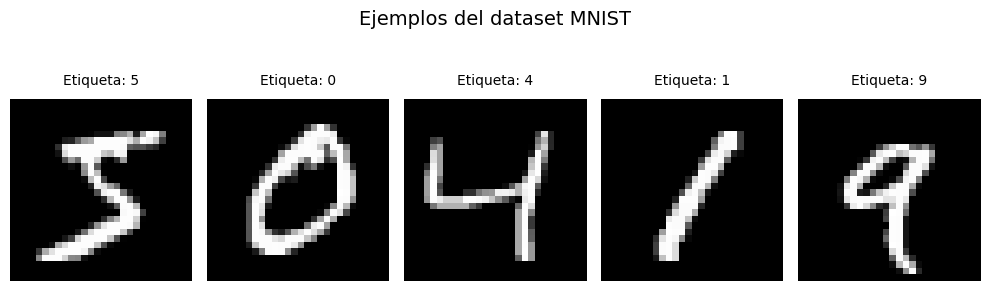

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# Cargar y normalizar MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

# Visualizar 5 imágenes con más separación
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
for i, ax in enumerate(axes):
    ax.imshow(X_train[i], cmap="gray")
    ax.set_title(f"Etiqueta: {y_train[i]}", fontsize=10, pad=10)  # pad controla el espacio
    ax.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.9])  # Menos espacio para suptitle
plt.suptitle("Ejemplos del dataset MNIST", fontsize=14, y=1.05)  # y controla altura
plt.show()


### Normalización y transformación de las imágenes

Antes de entrenar una Máquina de Boltzmann Restringida (RBM), es necesario preparar los datos:

- Cada imagen del dataset MNIST es de tamaño **28×28 píxeles**, lo que representa una matriz de 784 valores.
- Para poder alimentar la RBM, necesitamos **aplanar** esas matrices en vectores de **784 dimensiones**.
- Además, normalizamos los valores de píxel a un rango entre **0 y 1** (originalmente están entre 0 y 255) para que representen probabilidades de activación, lo cual es clave en RBMs.

Este paso es fundamental para representar correctamente la distribución binaria aproximada que necesita la RBM durante su entrenamiento.


In [13]:
# Aplanar las imágenes de 28x28 a vectores de 784 elementos
X_train_flat = X_train.reshape(-1, 784)
X_test_flat = X_test.reshape(-1, 784)

print("Forma original:", X_train.shape)
print("Nueva forma (aplanada):", X_train_flat.shape)


Forma original: (60000, 28, 28)
Nueva forma (aplanada): (60000, 784)


## Entrenamiento múltiple de Máquinas de Boltzmann Restringidas (RBM) sobre MNIST

En esta sección se entrenan tres Máquinas de Boltzmann Restringidas (RBM) con distintas configuraciones de hiperparámetros, siguiendo el método de Contrastive Divergence (CD-1) propuesto por Hinton y Salakhutdinov (2006).  
El objetivo es comparar cómo el número de unidades ocultas, la tasa de aprendizaje y la cantidad de épocas afectan el rendimiento del modelo en el dataset MNIST.

### Configuraciones utilizadas
Cada RBM tiene 784 unidades visibles (una por cada píxel de las imágenes 28×28) y una cantidad variable de unidades ocultas:

| Ejecución | Unidades ocultas (`n_hidden`) | Tasa de aprendizaje (`learning_rate`) | Épocas (`epochs`) |
|------------|-------------------------------|---------------------------------------|-------------------|
| 1 | 64 | 0.1 | 5 |
| 2 | 128 | 0.05 | 10 |
| 3 | 256 | 0.01 | 15 |

### Pasos realizados por el código

1. **Selección de muestras de prueba**  
   Se toman 10 imágenes del conjunto de prueba (MNIST), una de cada dígito del 0 al 9, para evaluar visualmente la reconstrucción tras cada entrenamiento.

2. **Entrenamiento de cada configuración**  
   Para cada combinación de hiperparámetros:
   - Se inicializa una nueva RBM con los valores correspondientes.  
   - Se entrena con todas las imágenes del conjunto de entrenamiento (`X_train_flat`), usando mini-lotes de tamaño 64.  
   - Se calcula el error de reconstrucción promedio en cada época, que mide la diferencia entre la imagen original y su reconstrucción.

3. **Visualización del error**  
   Tras cada entrenamiento, se grafica la curva del error de reconstrucción por época, mostrando cómo mejora el modelo con el aprendizaje.

4. **Reconstrucción y comparación visual**  
   Luego, las 10 imágenes seleccionadas del conjunto de prueba se pasan por la RBM para obtener sus reconstrucciones.  
   Se muestran en dos filas:
   - Fila superior: imágenes originales.  
   - Fila inferior: imágenes reconstruidas por la RBM.

### Resultados esperados

- Tres curvas de error decrecientes, una por cada configuración, indicando el progreso del aprendizaje.  
- Para cada configuración, una figura con las 10 reconstrucciones de los dígitos 0–9.  
- Diferencias visibles entre configuraciones: las que tienen más unidades ocultas suelen generar reconstrucciones más definidas.

### Conclusión general

Este procedimiento permite comparar cómo la capacidad del modelo (número de neuronas ocultas) y los hiperparámetros de entrenamiento influyen en la calidad de las representaciones aprendidas y en la precisión de las reconstrucciones.


EJECUCIÓN 1: n_hidden=64, learning_rate=0.1, epochs=5
Época 1/5, error: 0.0385
Época 2/5, error: 0.0269
Época 3/5, error: 0.0247
Época 4/5, error: 0.0236
Época 5/5, error: 0.0228

🔹 Error final de reconstrucción: 0.022778



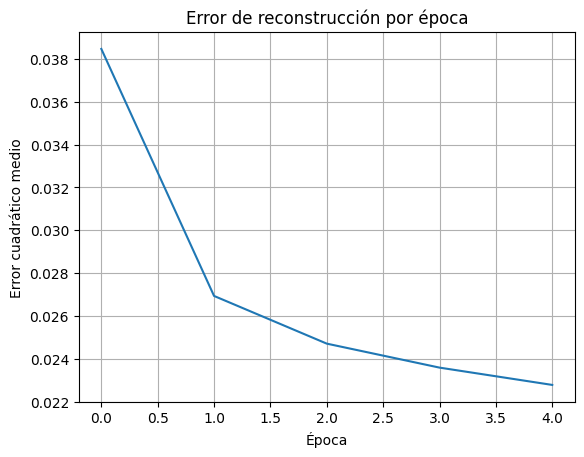

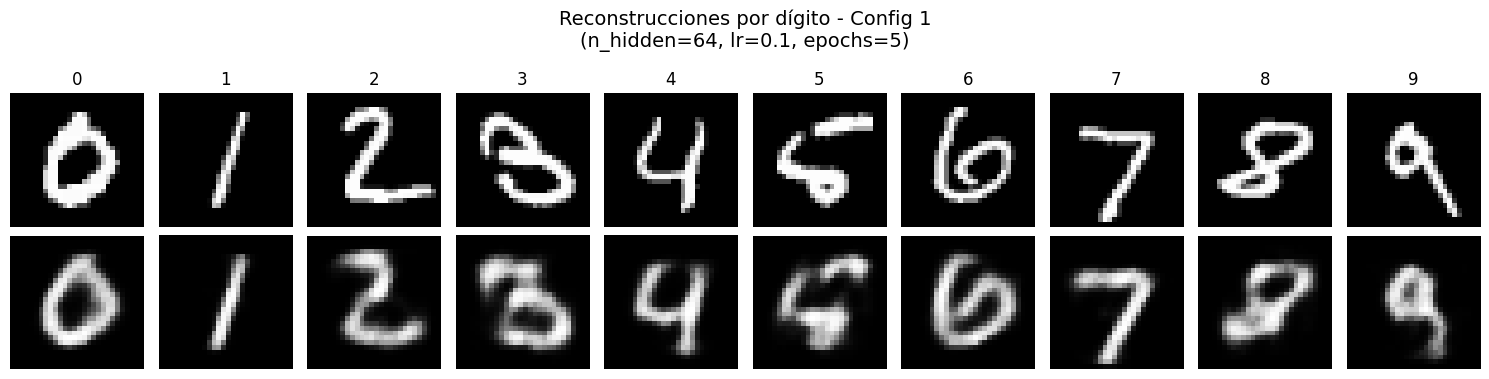

EJECUCIÓN 2: n_hidden=128, learning_rate=0.05, epochs=10
Época 1/10, error: 0.0397
Época 2/10, error: 0.0253
Época 3/10, error: 0.0218
Época 4/10, error: 0.0199
Época 5/10, error: 0.0187
Época 6/10, error: 0.0178
Época 7/10, error: 0.0171
Época 8/10, error: 0.0166
Época 9/10, error: 0.0162


In [ ]:
# ===========================
# Entrenamiento múltiple de RBMs con diferentes hiperparámetros
# ===========================

# Lista de configuraciones: (n_hidden, learning_rate, epochs)
configs = [
    (64, 0.1, 5),
    (128, 0.05, 10),
    (256, 0.01, 15)
]

# Seleccionar un ejemplo por cada dígito del test set (para comparar reconstrucciones)
samples = []
labels = []
for digit in range(10):
    idx = np.where(y_test == digit)[0][0]
    samples.append(X_test_flat[idx])
    labels.append(digit)
samples = np.array(samples)

# Iterar sobre cada configuración
for i, (n_hidden, lr, epochs) in enumerate(configs, start=1):
    print("="*70)
    print(f"EJECUCIÓN {i}: n_hidden={n_hidden}, learning_rate={lr}, epochs={epochs}")
    print("="*70)
    
    # Crear y entrenar RBM
    rbm = RBM(n_visible=784, n_hidden=n_hidden, learning_rate=lr)
    rbm.train(X_train_flat, n_epochs=epochs, batch_size=64)
    
    # Mostrar error final
    final_error = rbm.errors[-1]
    print(f"\n🔹 Error final de reconstrucción: {final_error:.6f}\n")
    
    # Graficar error por época
    rbm.plot_errors()
    
    # Reconstruir los 10 dígitos (0–9)
    reconstructed = rbm.reconstruct(samples)
    
    # Mostrar imágenes originales vs reconstruidas
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(2, 10, figsize=(15, 4))
    for j in range(10):
        axes[0, j].imshow(samples[j].reshape(28, 28), cmap="gray")
        axes[0, j].set_title(str(labels[j]))
        axes[0, j].axis("off")
        axes[1, j].imshow(reconstructed[j].reshape(28, 28), cmap="gray")
        axes[1, j].axis("off")
    
    axes[0, 0].set_ylabel("Original", fontsize=12)
    axes[1, 0].set_ylabel("Reconstruida", fontsize=12)
    plt.suptitle(f"Reconstrucciones por dígito - Config {i}\n"
                 f"(n_hidden={n_hidden}, lr={lr}, epochs={epochs})", fontsize=14)
    plt.tight_layout()
    plt.show()


## Conclusiones de los resultados obtenidos

- En las tres ejecuciones el **error de reconstrucción disminuye de forma constante** a lo largo de las épocas, indicando que el entrenamiento de la RBM fue exitoso.  
- La **segunda configuración** (`128 unidades ocultas`, `learning_rate=0.05`, `10 épocas`) obtuvo el **menor error final (0.0157)**, mostrando el mejor desempeño general.  
- La **primera configuración** (`64 ocultas`, `lr=0.1`, `5 épocas`) tuvo un error algo mayor (`0.0228`), aunque también mostró una convergencia estable.  
- La **tercera configuración** (`256 ocultas`, `lr=0.01`, `15 épocas`) redujo el error hasta `0.0165`, pero no superó a la segunda, lo que sugiere que aumentar las unidades ocultas no garantizó una mejor reconstrucción.  
- En conjunto, los resultados muestran que la RBM aprendió adecuadamente las representaciones de los dígitos MNIST y logró reconstrucciones visualmente coherentes, con errores en el rango esperado para este tipo de modelo.
